# Datojen haku ja esikäsittely

In [1]:
from set_path import set_path
mainpath, path = set_path('areadata')

In [2]:
from read_and_prepare_data import read_and_prepare_data
stat, post, kunta_stat, vaalidata = read_and_prepare_data(path)

read_and_prepare_data  read from file
read_post_muncipalities  read from file


In [3]:
from selected_cols import selected_cols
numeric_features, categorical_features = selected_cols(largeset=False, parties=True)

load model
Number of clusters: 6 Silhouette Coefficient: 0.158 Calinski Harabaz Index: 307
1    1027
4     960
3     352
5     348
0     151
2     132
Name: cluster, dtype: int64


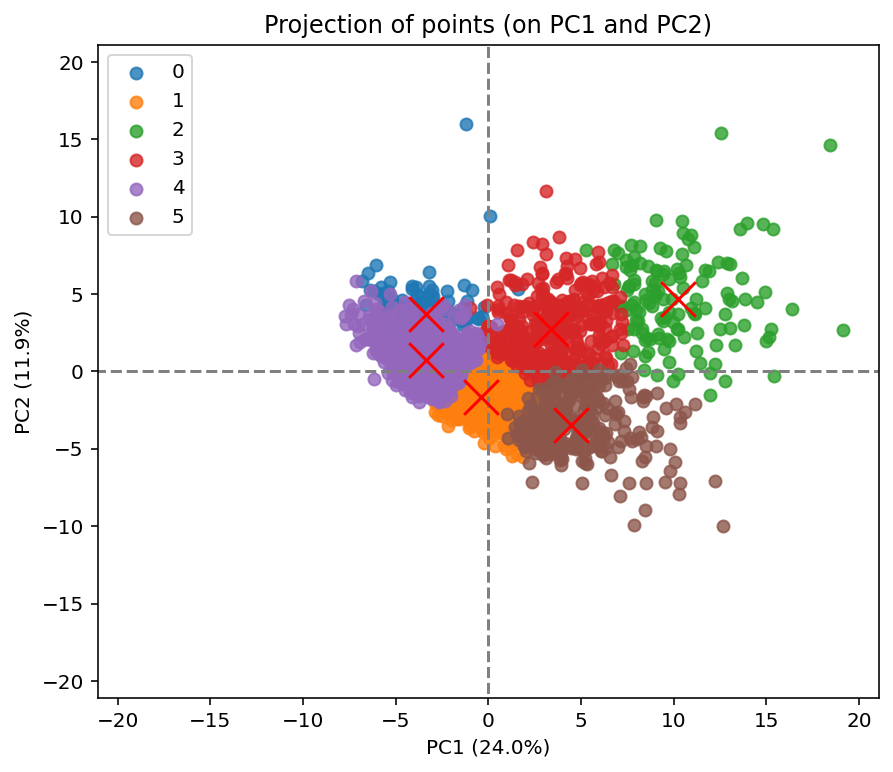

In [4]:
from sklearn.feature_selection import  mutual_info_classif
import pandas as pd
from sklearn.cluster import KMeans
import shap

from draw_and_create_clusters import create_kmeans_clusters 
from draw_and_create_clusters import draw_clusters, display_circles, display_parallel_coordinates_centroids, display_factorial_planes

from prepare_and_scale_data import prepare_and_scale_data
from create_prediction import select_kbest
from select_columns_and_clean_data import select_columns_and_clean_data
from draw_all import draw_features

from shap_Xboost import shap_Xboost
from shap_proba_individual import print_reason, print_individual_waterfall
from shap_vals import shap_vals
from print_examples import plot_difference, create_example_df, find_most_different, show_real_share
from create_target_columns import create_target_columns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_colwidth = 100

list_of_parties = ['VIHR', 'KOK', 'SDP', 'KD', 'KESK', 'RKP', 'PS', 'VAS']
included_col_start = 'Ääniosuus'
all_included_columns = create_target_columns(list_of_parties, included_col_start)
included_col_start = 'Äänet yhteensä lkm'
all_included_columns_2 = create_target_columns(list_of_parties, included_col_start)
share_of_votes = 'Ääniosuus'
total_votes = 'Äänet yhteensä lkm Äänioikeutetut yhteensä'


n_components = 2
n_clusters = 6
axis_ranks=  [(0,1)]
alpha = 0.8
scaled = True
silhouette_print = 0

filename_model = 'kmeans_cluster'
data, X, test, kmeans = create_kmeans_clusters(filename_model, path, stat, stat, numeric_features=numeric_features, categorical_features=categorical_features, n_clusters=n_clusters, silhouette_print=silhouette_print, scaled=scaled)

print(data['cluster'].value_counts())
display_factorial_planes(kmeans, data, X, n_components=n_components, axis_ranks=axis_ranks, labels=None, alpha=alpha)

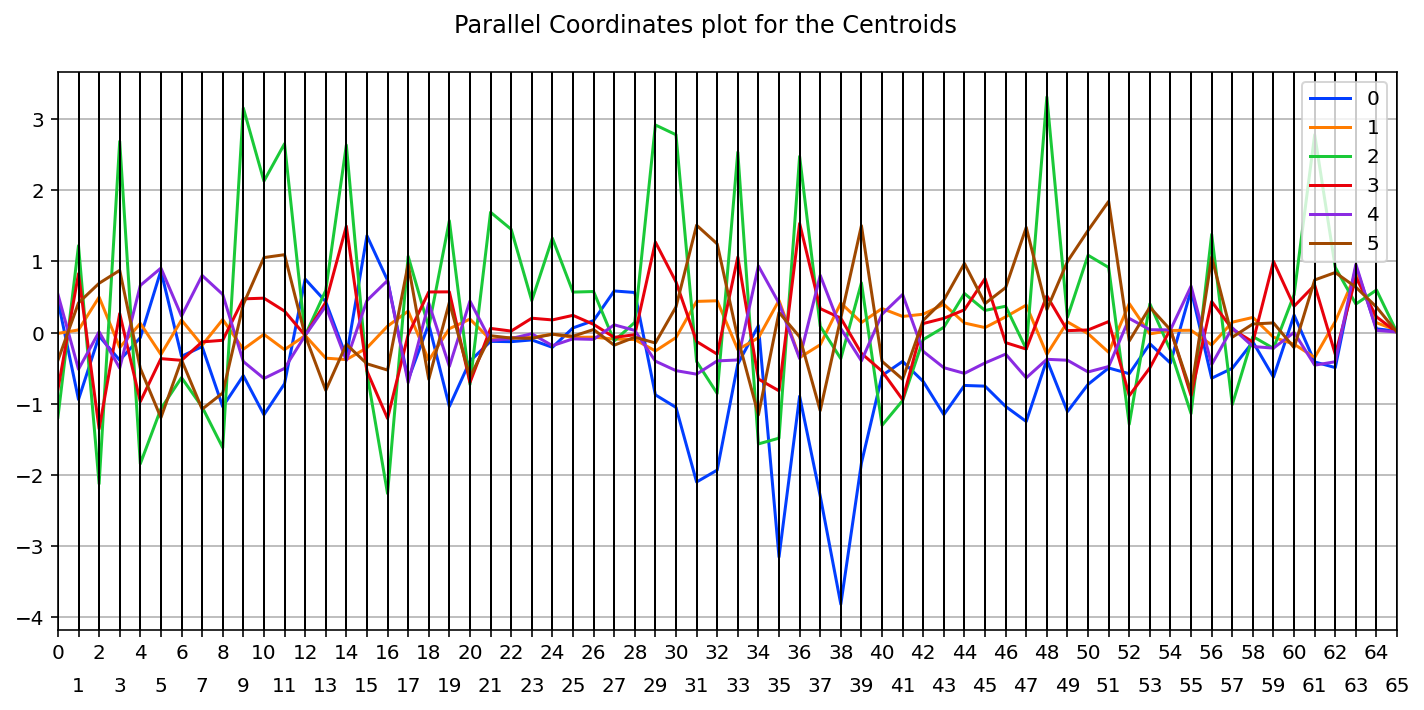

In [5]:
labels = [X.columns.get_loc(c) for c in X.columns]
centroids=display_parallel_coordinates_centroids(kmeans, labels=labels)
cols = X.columns.to_list()
cols.append('cluster')
centroids.columns = cols

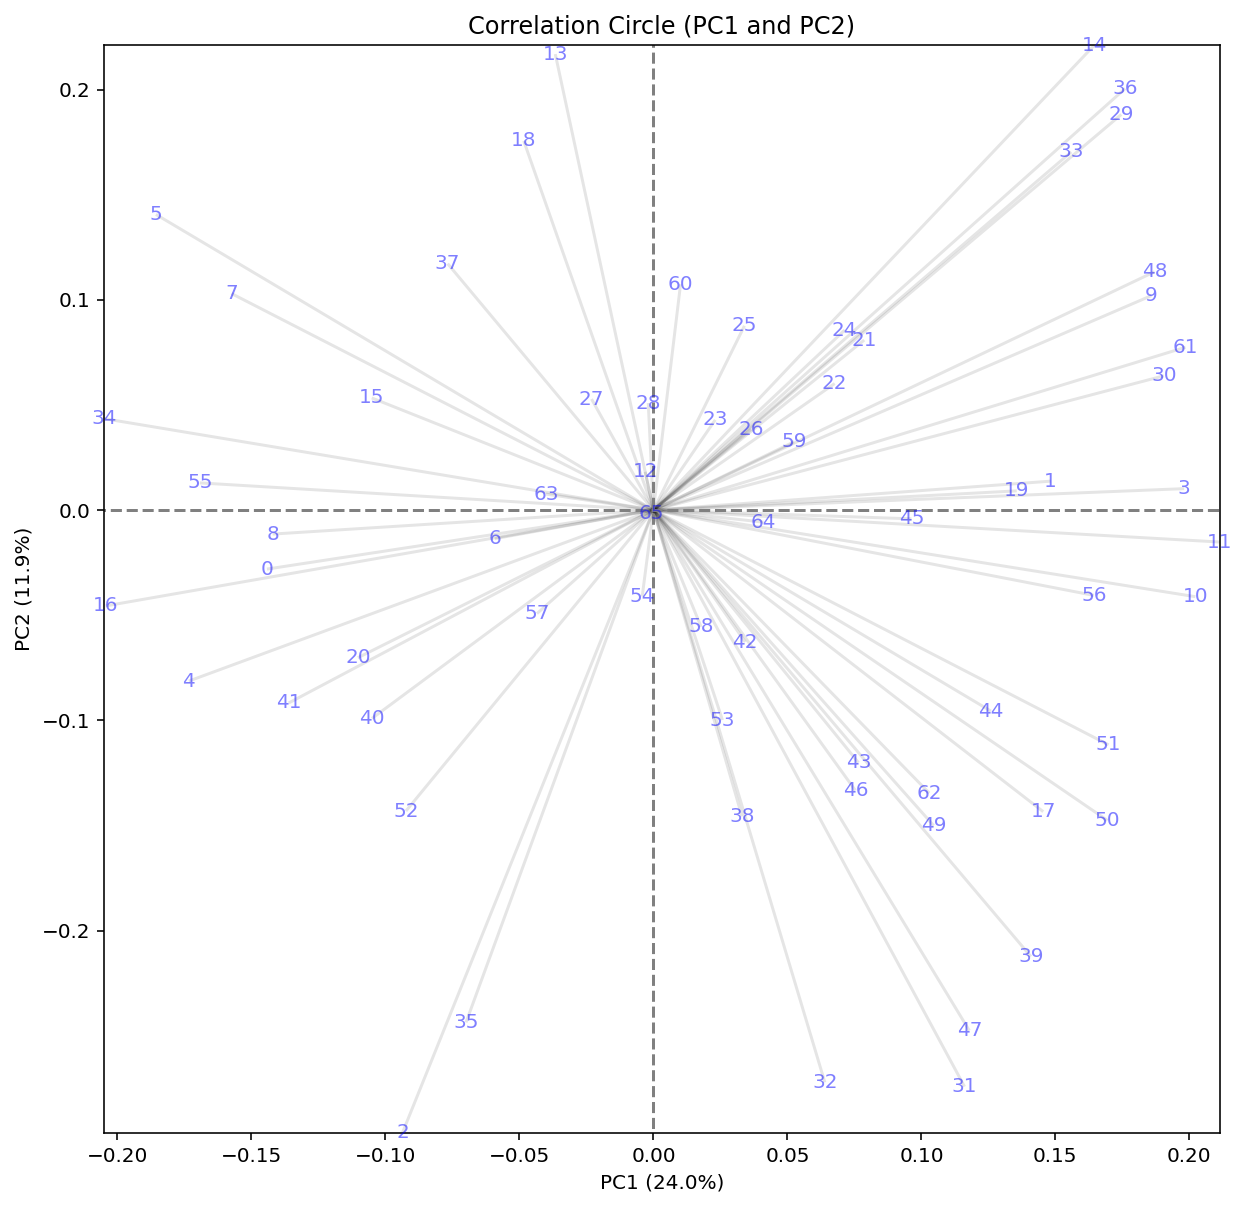

In [6]:
axis_ranks =  [(0,1)]
n_components = 2
labels = [X.columns.get_loc(c) for c in X.columns]

pcs = display_circles(X, n_components=n_components, axis_ranks=axis_ranks, labels=labels, label_rotation=0, lims=None)

In [7]:
for c in X.columns:
    print(X.columns.get_loc(c), c)

0 Miehet, 2018 (HE) osuudesta asukkaat
1 Naiset, 2018 (HE) osuudesta asukkaat
2 Asuntojen keskipinta-ala, 2018 (RA) osuus total
3 Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total
4 Asumisväljyys, 2018 (TE) osuus total
5 Asukkaiden keski-ikä, 2018 (HE) osuus total
6 Postinumeroalueen pinta-ala osuus area_code
7 Perusasteen suorittaneet, 2018 (KO) osuudesta asukkaat
8 Ammatillisen tutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
9 Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
10 Alemman korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
11 Ylemmän korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
12 Asukkaiden ostovoimakertymä, 2017 (HR) osuudesta asukkaat osuus total
13 Asunnot, 2018 (RA) osuudesta asukkaat
14 Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat
15 Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat
16 Pientaloasunnot, 2018 (RA) osuudesta asukkaat
17 Työlliset, 2017 (PT) osuudesta asukkaat
18 Työttömät, 2017 (PT) osuudesta

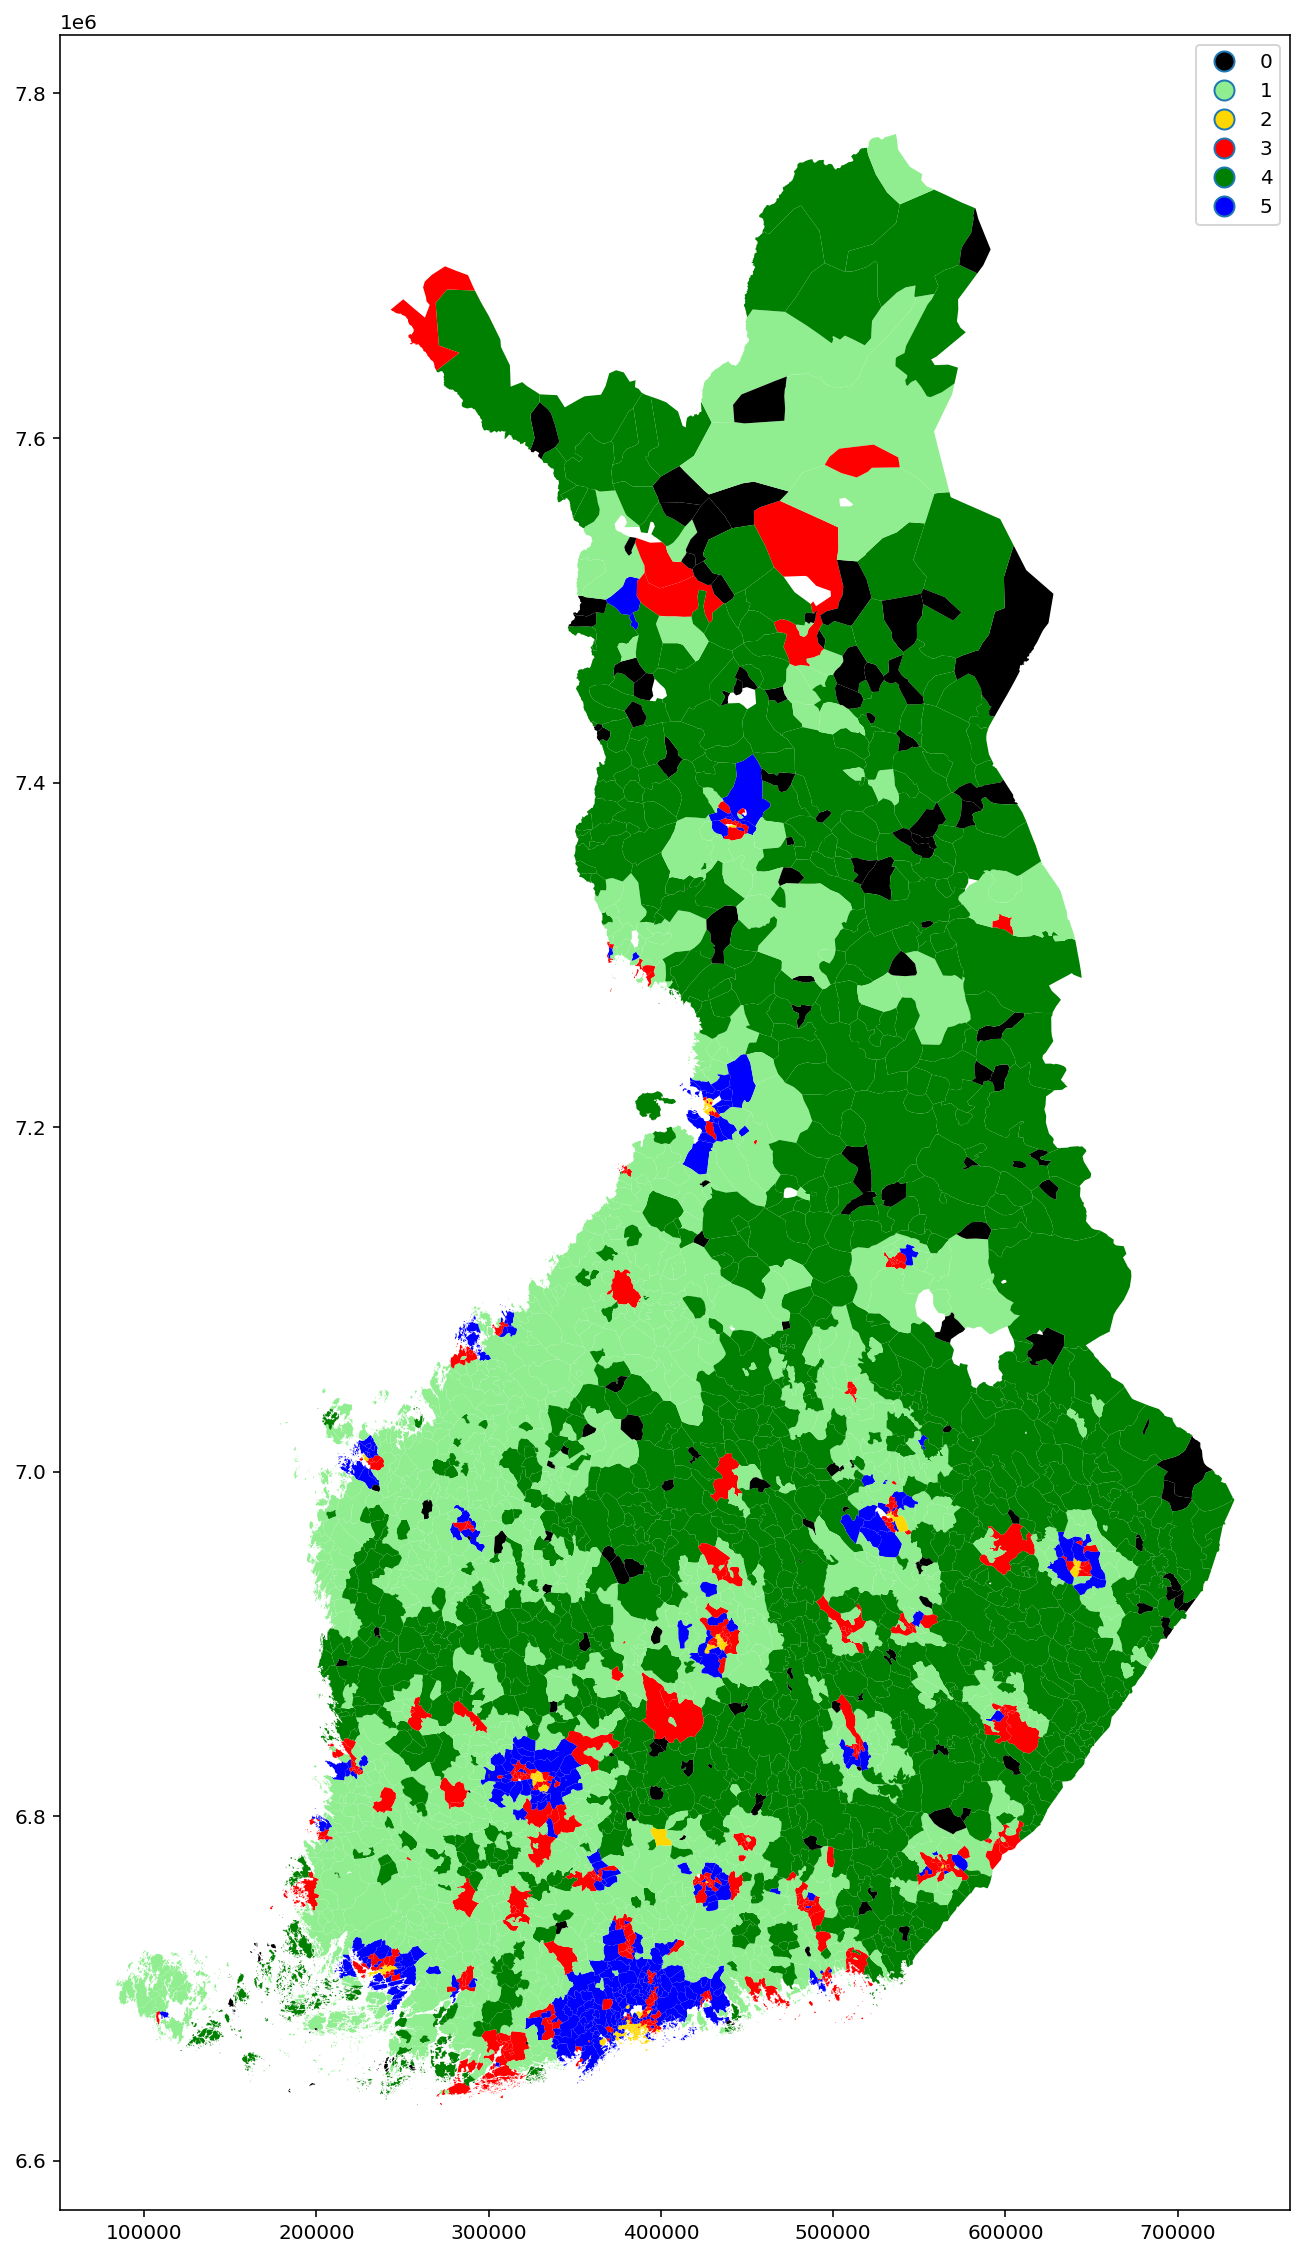

In [8]:
import geopandas
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('my cmap', ['black', 'lightgreen', 'gold',  'red',  'green', 'blue'])
draw = geopandas.GeoDataFrame(pd.DataFrame(data[['cluster', 'geometry']], dtype=object),geometry='geometry')
draw.plot(column='cluster', cmap=cmap, legend=True, figsize=(20,20))

In [9]:
import xgboost as xgb
from sklearn.feature_selection import  mutual_info_classif
from create_prediction import create_prediction

target = 'cluster'

ennustettu = "uusi" + target

#Check
#k_selected need to have correct values, if they are too large, evrything needs to be started again
k_selected = 'all'

test_size = 0.2

#Scalers attributes
kbest_score_func = mutual_info_classif
#set values to model configuration attributes

num_class = len(data['cluster'].unique()) #how many classes we are working with

metric = 'merror'
Skfold=True
Verbose = False
testing=True
scaled = False

params = {
    # Parameters that we are going to tune.
    'objective':'multi:softmax',
    'num_class' : num_class,
    'booster' : 'gbtree',
    'eval_metric' : metric
}

filename_model = 'kmeans_xgboost_cluster'
data, test, features_df, importance_df, model, params, y_pred, X_train, y_train, X_test, y_test = create_prediction(filename_model, path, data, data, target, kbest_score_func, metric, params, numeric_features, categorical_features, scaled=scaled, testing=testing)
data_no_use, X_scale, X = prepare_and_scale_data(data, pd.DataFrame(), numeric_features, categorical_features)


load model


In [10]:
filename_model = 'kmeans_mymodel_xgboost_cluster'
filename_shap =  'kmeans_shap.npz'
mymodel, shap_values, shap_interaction_values, shap_expected_value = shap_Xboost(filename_model, filename_shap, path, data, target, params, X)


load model
load shap files


In [11]:
data[data['cluster']==1][features_df['Column'].head(5).to_list()].describe()

Pientaloasunnot, 2018 (RA) osuudesta asukkaat  \
count                                    1027.000000   
mean                                        0.474941   
std                                         0.054652   
min                                         0.289757   
25%                                         0.439422   
50%                                         0.477938   
75%                                         0.509885   
max                                         0.708155   

       Lapsitaloudet, 2018 (TE) osuudesta taloudet  \
count                                  1027.000000   
mean                                      0.239633   
std                                       0.053094   
min                                       0.000000   
25%                                       0.202797   
50%                                       0.234375   
75%                                       0.269681   
max                                       0.490654   

       Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
count                                                            1027.000000   
mean                                                                0.231952   
std                                                                 0.059616   
min                                                                 0.060606   
25%                                                                 0.187054   
50%                                                                 0.229730   
75%                                                                 0.274824   
max                                                                 0.421053   

       Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
count                                                      1027.000000   
mean                                                          0.881744   
std                                                           0.086300   
min                                                           0.000000   
25%                                                           0.830382   
50%                                                           0.908163   
75%                                                           0.947368   
max                                                           1.000000   

       11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut  
count                                                                1027.000000  
mean                                                                    0.162306  
std                                                                     0.073048  
min                                                                     0.000000  
25%                                                                     0.109540  
50%                                                                     0.157143  
75%                                                                     0.212359  
max                                                                     0.487500

In [12]:
importance_df[importance_df['Importance type']==importance_df['Importance type'].unique()[1]].head(15)

Feature  \
64                                           Lapsitaloudet, 2018 (TE) osuudesta taloudet   
65                                   Eläkeläisten taloudet, 2018 (TE) osuudesta taloudet   
66                 Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet   
67                                         Pientaloasunnot, 2018 (RA) osuudesta asukkaat   
68                              1.1 Tuloverot yhteensä Yhteensä Summa, euroa osuus total   
69  11.5.1.1 Asuntolainan korkomenot (TVL 58 § 2 mom.) Yhteensä Summa, euroa osuus total   
70             11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut   
71                                Perusasteen suorittaneet, 2018 (KO) osuudesta asukkaat   
72                                       4.1.C Autoetu Yhteensä Summa, euroa osuus total   
73            Keskimmäiseen tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet   
74                           Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet   
75                 Ylimpään tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet   
76                                                                        Ääniosuus VIHR   
77                       Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet   
78                                           Asukkaiden keski-ikä, 2018 (HE) osuus total   

          Score Importance type  
64  1025.190055      total_gain  
65   991.672927      total_gain  
66   835.442244      total_gain  
67   667.876830      total_gain  
68   533.104103      total_gain  
69   460.879156      total_gain  
70   429.032068      total_gain  
71   404.409621      total_gain  
72   360.709764      total_gain  
73   339.497817      total_gain  
74   334.008199      total_gain  
75   328.772757      total_gain  
76   308.555300      total_gain  
77   293.290911      total_gain  
78   276.982043      total_gain

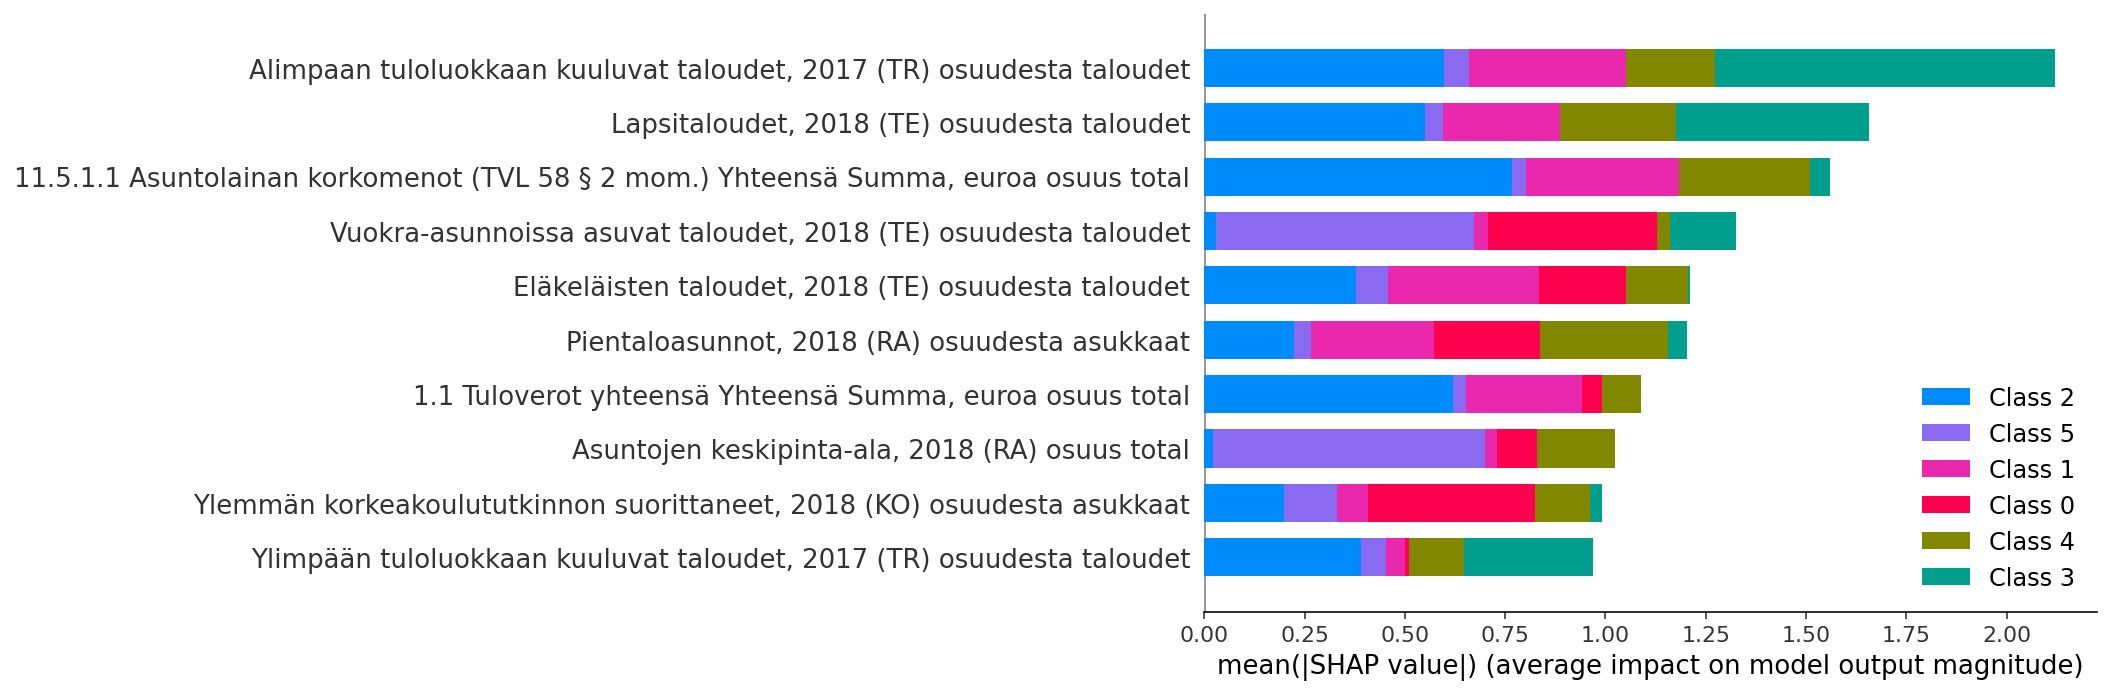

In [13]:
shap.summary_plot(shap_values, X,  max_display=10)

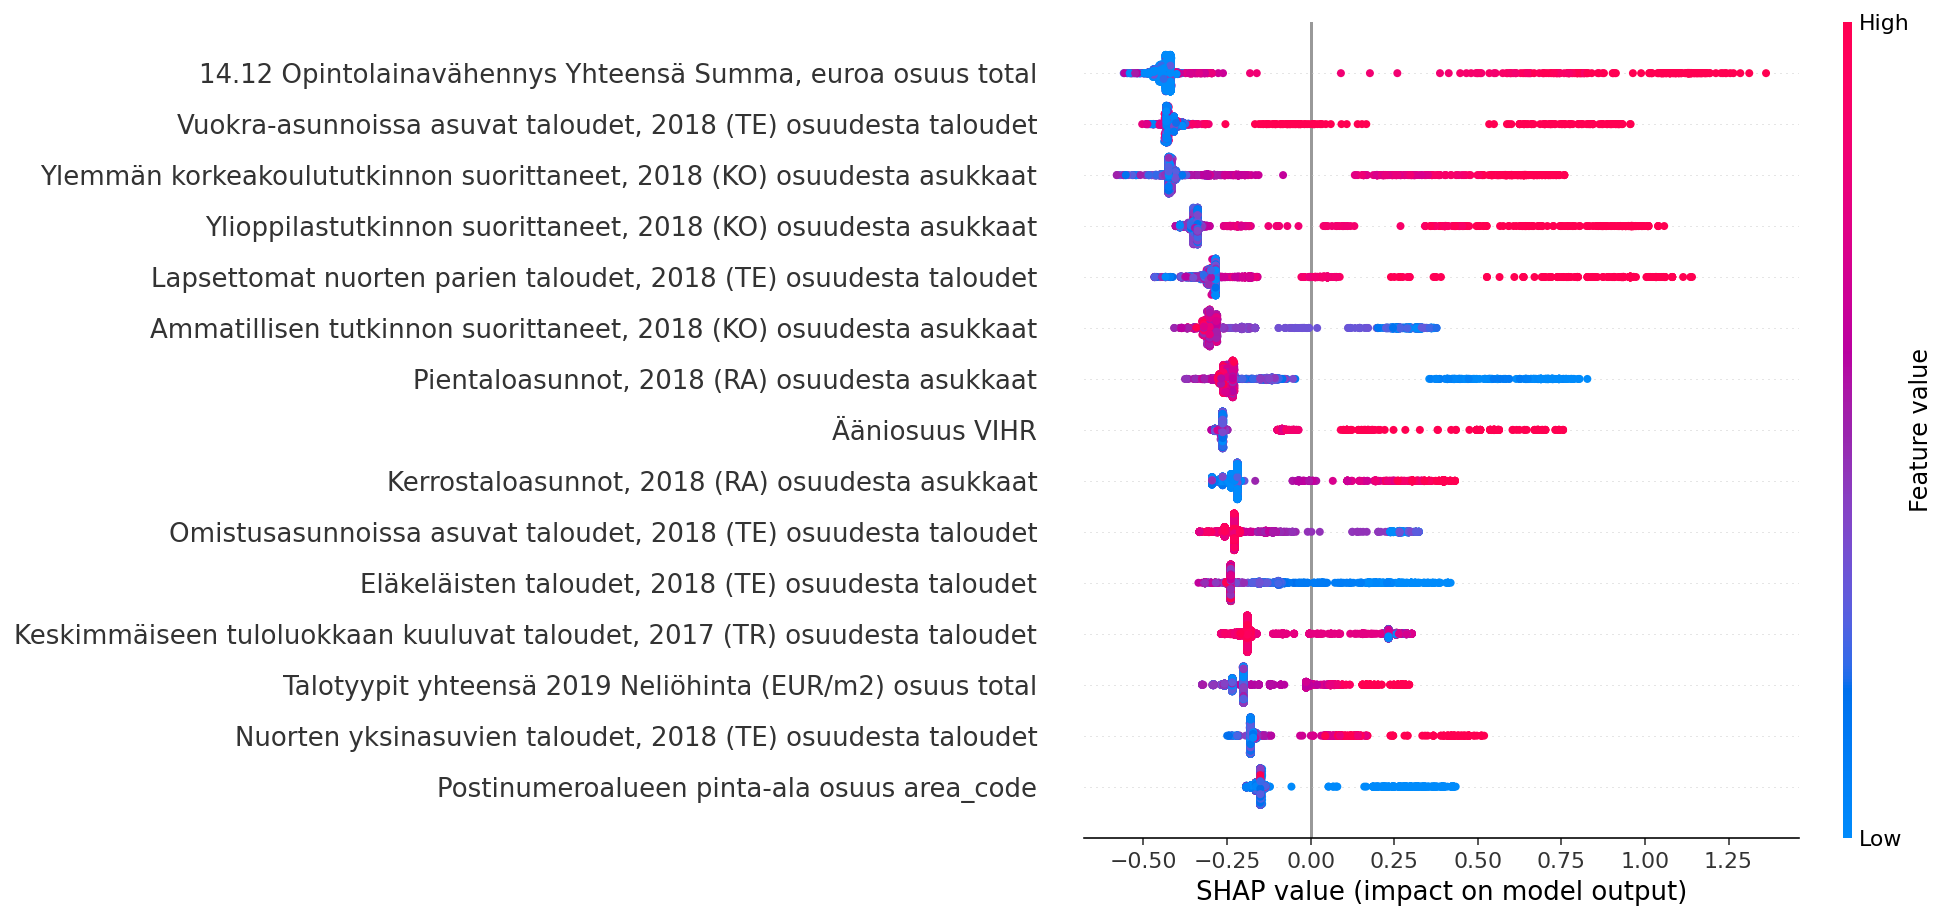

In [14]:
shap_index = 0
col_num = 7
compare_to = data[(data['cluster']) == shap_index].copy()
included_columns = []
shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


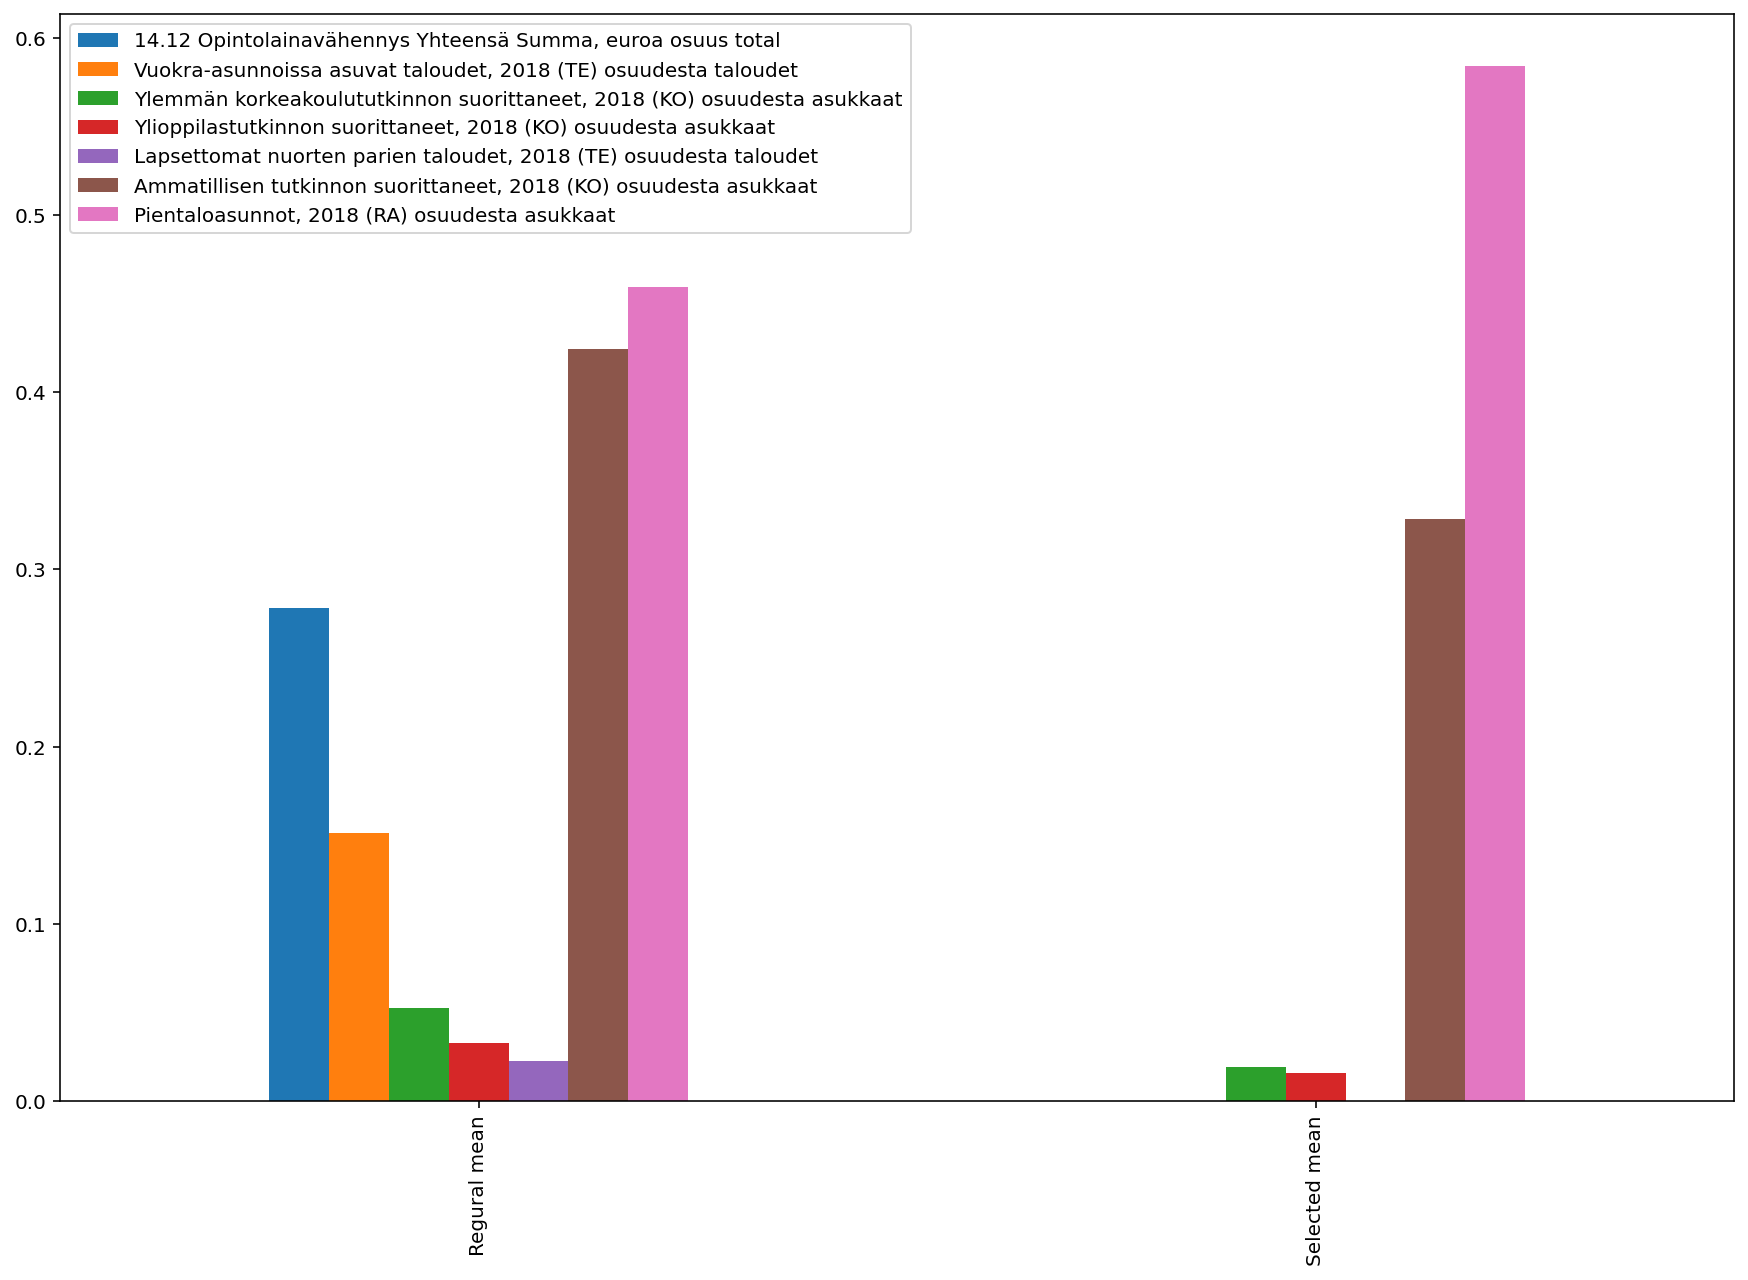

In [15]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=col_num, scaled=False)

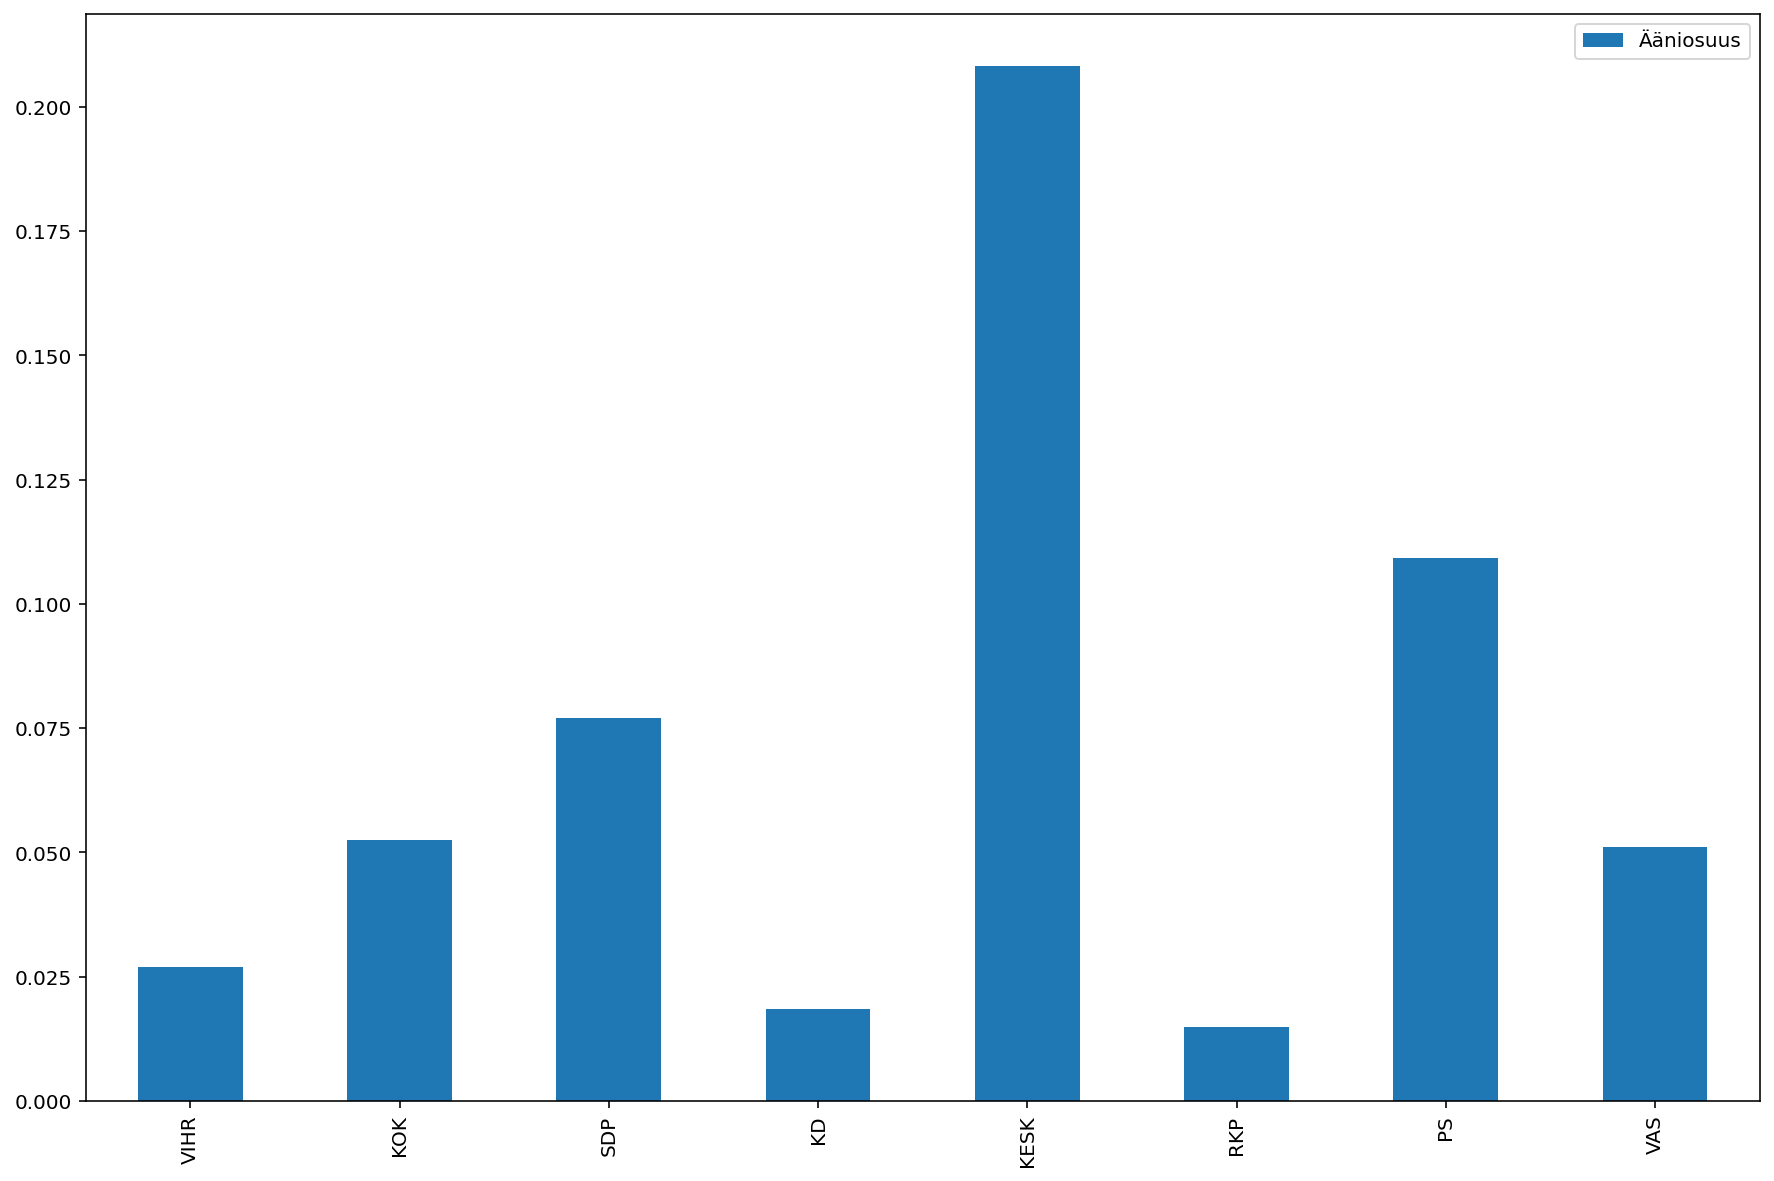

In [16]:
aanet = show_real_share(compare_to, all_included_columns_2, share_of_votes, total_votes, list_of_parties)

In [17]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=col_num)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
2941       98980      KALLUNKI            Salla                          32.0   
1723       61150      SYDÄNMAA           Alavus                          69.0   
2679       93180   IKOSENNIEMI       Pudasjärvi                          25.0   
1484       51620      PITKÄAHO          Mikkeli                          18.0   
1107       42830    YLÄ-KOLKKI  Mänttä-Vilppula                          54.0   

     Suurin_puolue  \
2941          KESK   
1723          KESK   
2679          KESK   
1484          KESK   
1107          KESK   

      Ammatillisen tutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
2941                                                           0.593750   
1723                                                           0.420290   
2679                                                           0.000000   
1484                                                           0.000000   
1107                                                           0.388889   

      Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
2941                                                        0.031250   
1723                                                        0.014493   
2679                                                        0.000000   
1484                                                        0.000000   
1107                                                        0.000000   

      Ylemmän korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
2941                                                                      0.0   
1723                                                                      0.0   
2679                                                                      0.0   
1484                                                                      0.0   
1107                                                                      0.0   

      Pientaloasunnot, 2018 (RA) osuudesta asukkaat  \
2941                                       0.781250   
1723                                       0.565217   
2679                                       0.640000   
1484                                       0.777778   
1107                                       0.518519   

      Lapsettomat nuorten parien taloudet, 2018 (TE) osuudesta taloudet  \
2941                                                                0.0   
1723                                                                0.0   
2679                                                                0.0   
1484                                                                0.0   
1107                                                                0.0   

      Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
2941                                                              0.0   
1723                                                              0.0   
2679                                                              0.0   
1484                                                              0.0   
1107                                                              0.0   

      14.12 Opintolainavähennys Yhteensä Summa, euroa osuus total  
2941                                                          0.0  
1723                                                          0.0  
2679                                                          0.0  
1484                                                          0.0  
1107                                                          0.0

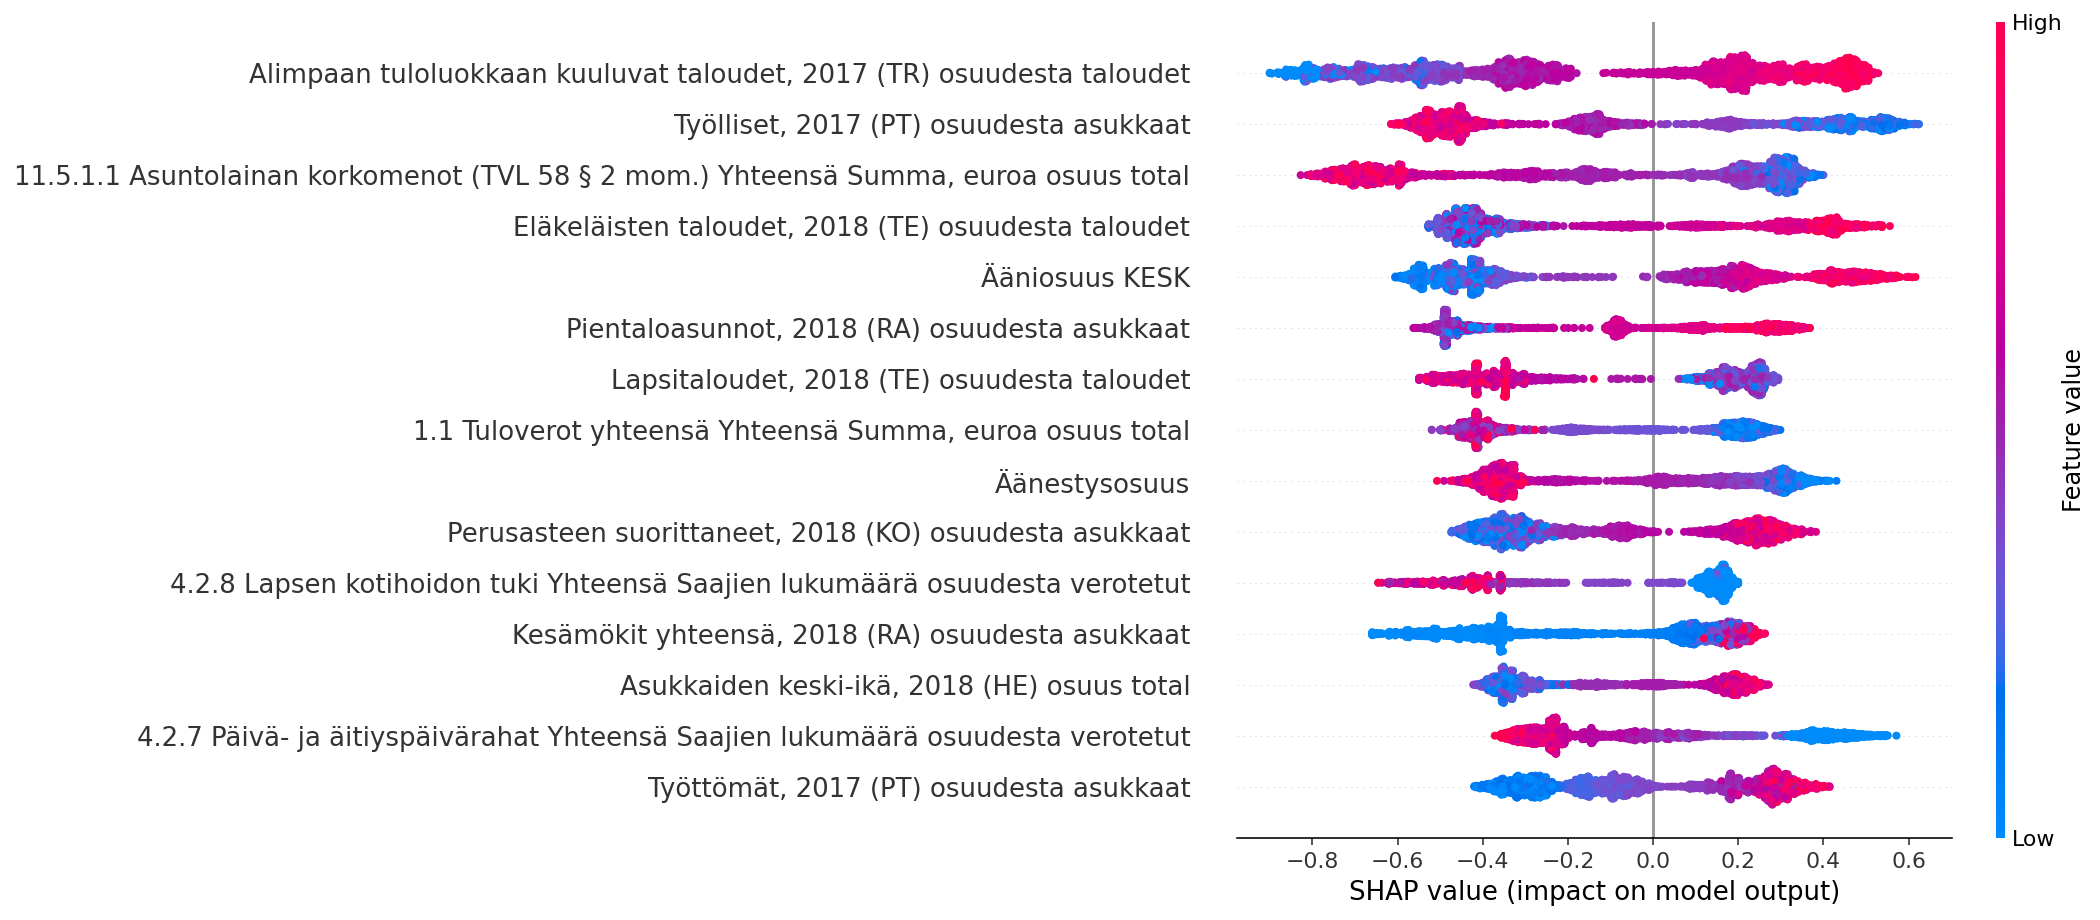

In [18]:
shap_index = 1
col_num = 7
compare_to = data[(data['cluster']) == shap_index].copy()
incl_mean = find_most_different(data, compare_to, all_included_columns,'mean')
incl_std = find_most_different(data, compare_to, all_included_columns,'std')
included_columns = [incl_mean] + [incl_std]
shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


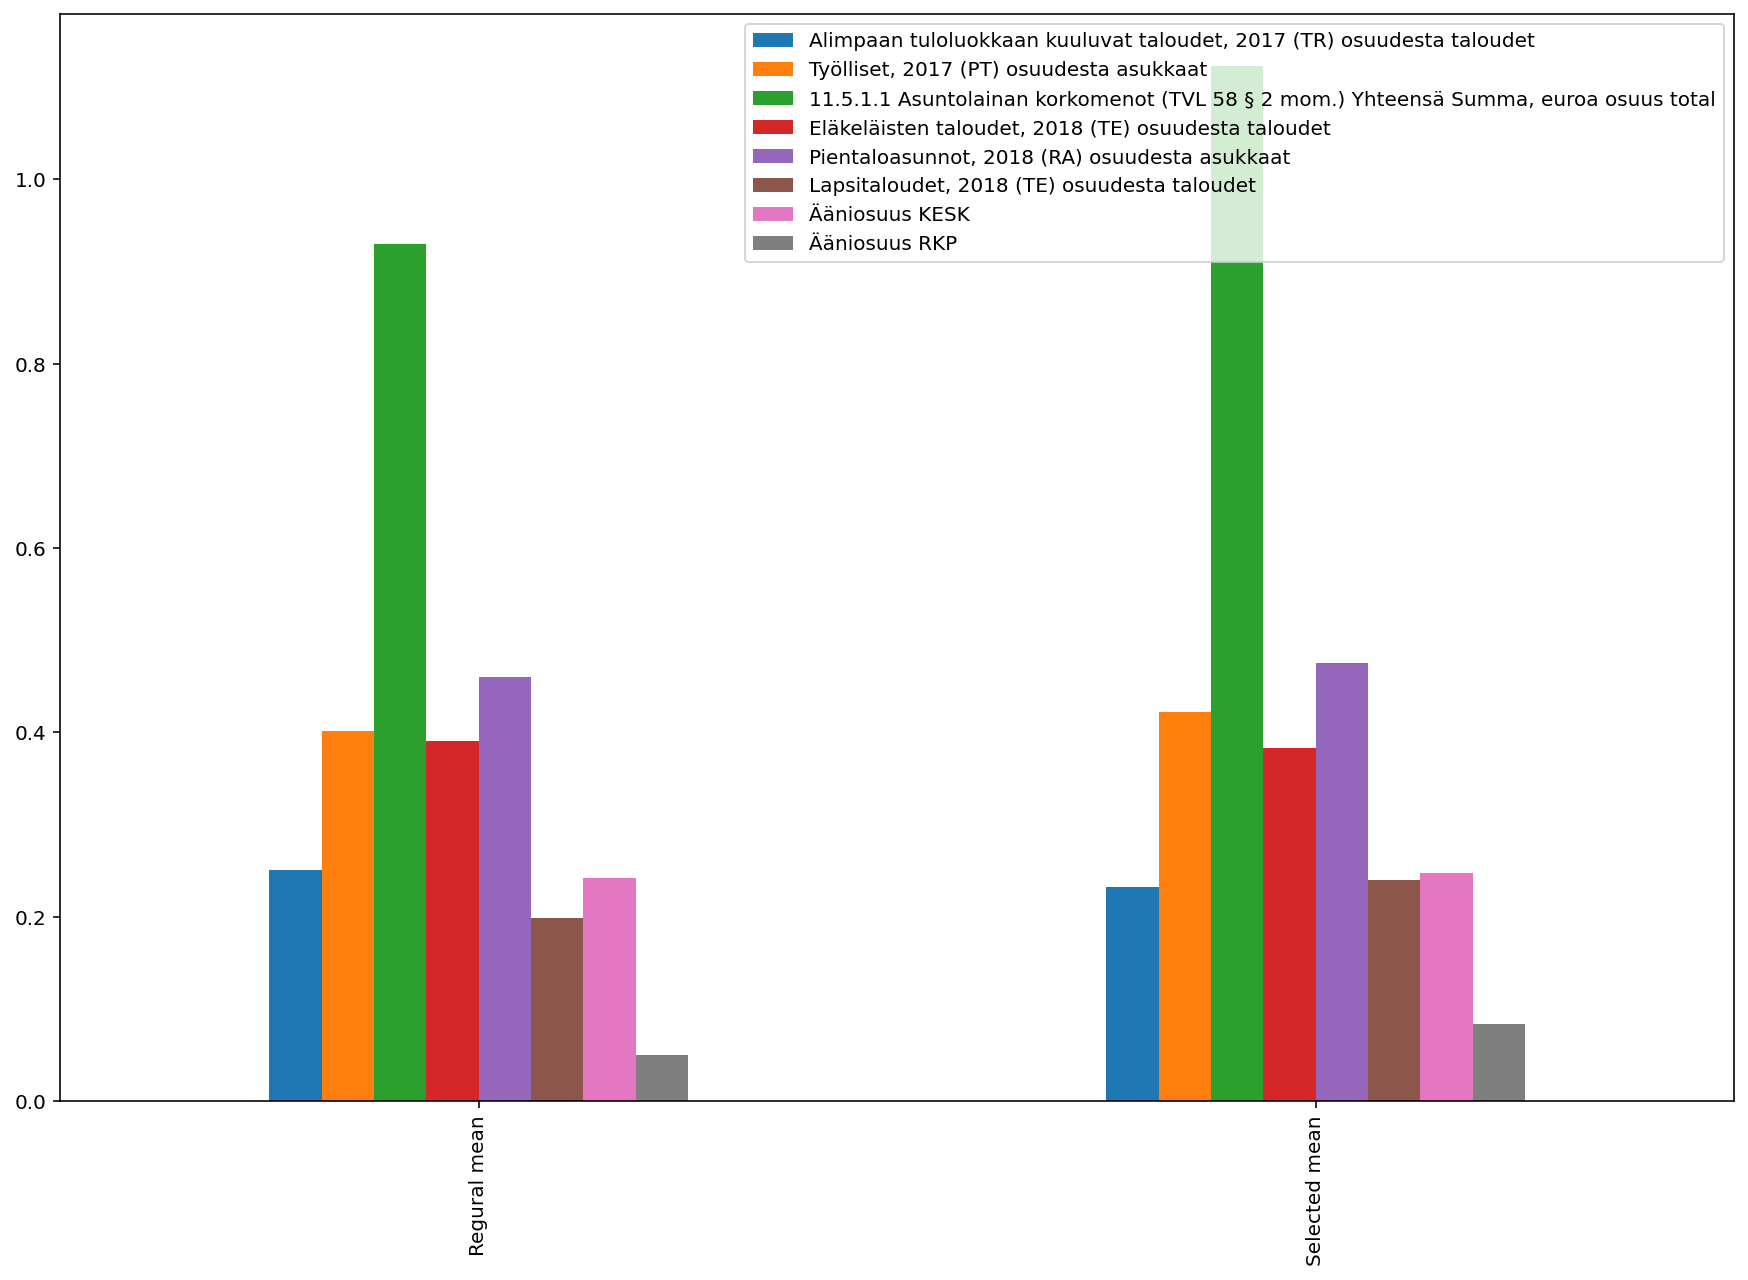

In [19]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=col_num, scaled=False)

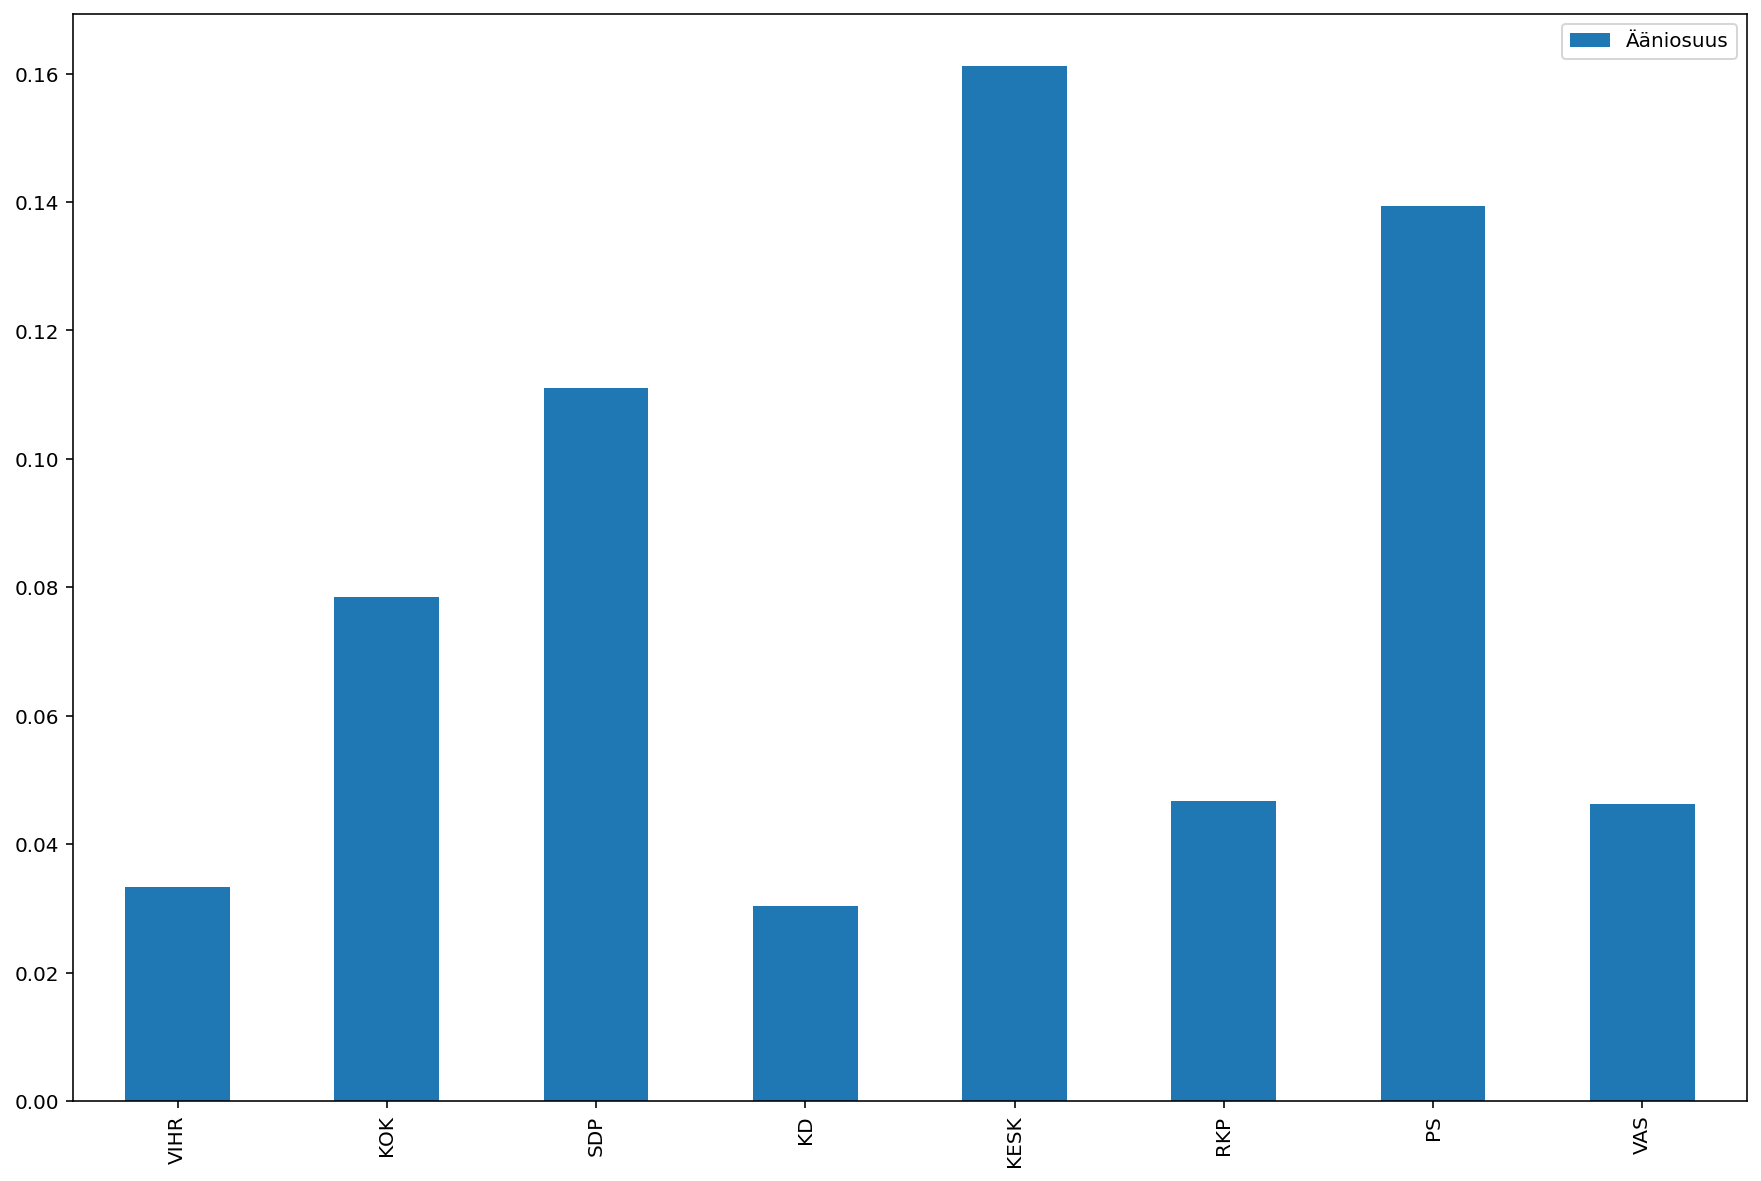

In [20]:
aanet = show_real_share(compare_to, all_included_columns_2, share_of_votes, total_votes, list_of_parties)

In [21]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=col_num)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
949        32560       VIRTTAA           Loimaa                         453.0   
411        14770     ETELÄINEN      Hämeenlinna                         924.0   
1671       58830     PARKUMÄKI       Rantasalmi                         285.0   
2124       71820         PÖLJÄ      Siilinjärvi                         819.0   
1946       66530    KOIVULAHTI       Mustasaari                        1898.0   

     Suurin_puolue  Pientaloasunnot, 2018 (RA) osuudesta asukkaat  \
949           KESK                                       0.496689   
411           KESK                                       0.430736   
1671          KESK                                       0.484211   
2124          KESK                                       0.387057   
1946           RKP                                       0.413593   

      Työlliset, 2017 (PT) osuudesta asukkaat  \
949                                  0.456954   
411                                  0.441558   
1671                                 0.382456   
2124                                 0.432234   
1946                                 0.468388   

      Lapsitaloudet, 2018 (TE) osuudesta taloudet  \
949                                      0.231884   
411                                      0.301630   
1671                                     0.250000   
2124                                     0.373333   
1946                                     0.334601   

      Eläkeläisten taloudet, 2018 (TE) osuudesta taloudet  \
949                                              0.400966   
411                                              0.334239   
1671                                             0.416667   
2124                                             0.296667   
1946                                             0.334601   

      Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
949                                                                0.202899   
411                                                                0.192935   
1671                                                               0.300000   
2124                                                               0.153333   
1946                                                               0.186312   

      11.5.1.1 Asuntolainan korkomenot (TVL 58 § 2 mom.) Yhteensä Summa, euroa osuus total  \
949                                                                               1.063216   
411                                                                               1.507276   
1671                                                                              0.698061   
2124                                                                              1.841773   
1946                                                                              1.432740   

      Ääniosuus KESK  
949         0.369085  
411         0.223776  
1671        0.368750  
2124        0.311594  
1946        0.007168

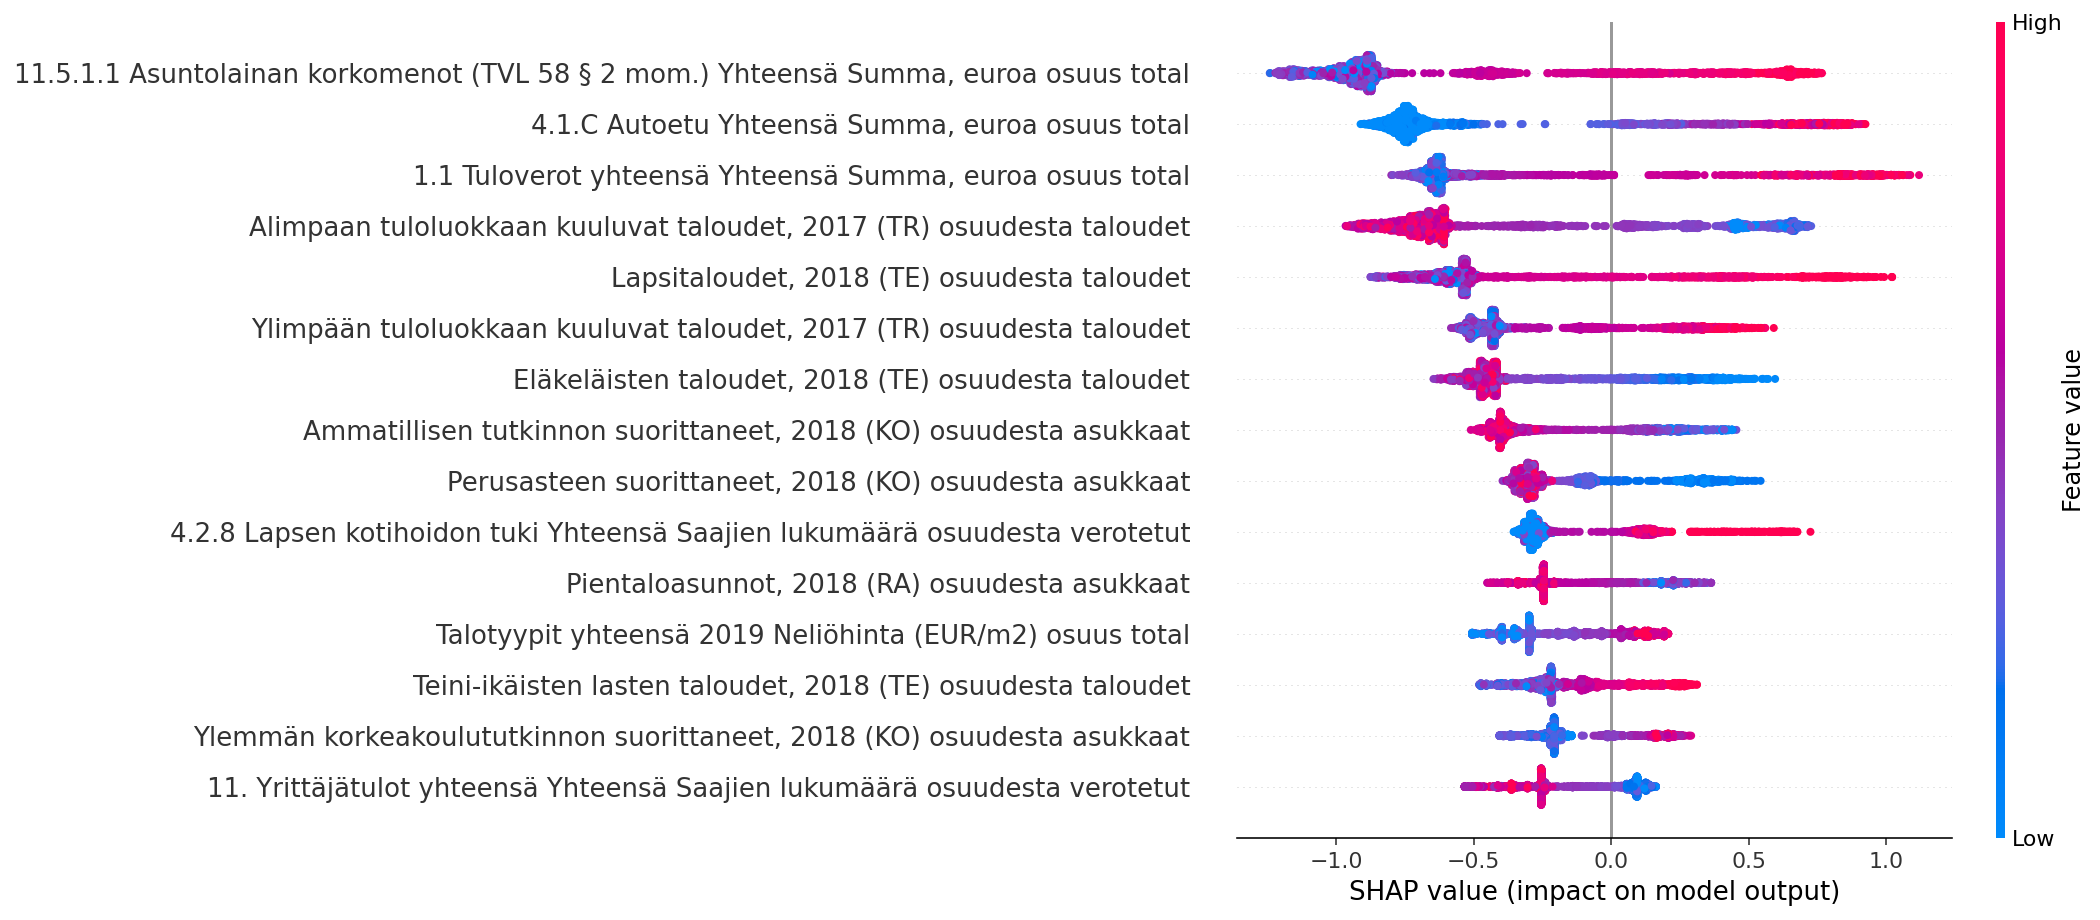

In [22]:
shap_index = 2
col_num = 7
compare_to = data[(data['cluster']) == shap_index].copy()
incl_mean = find_most_different(data, compare_to, all_included_columns,'mean')
incl_std = find_most_different(data, compare_to, all_included_columns,'std')
included_columns = [incl_mean] + [incl_std]
shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


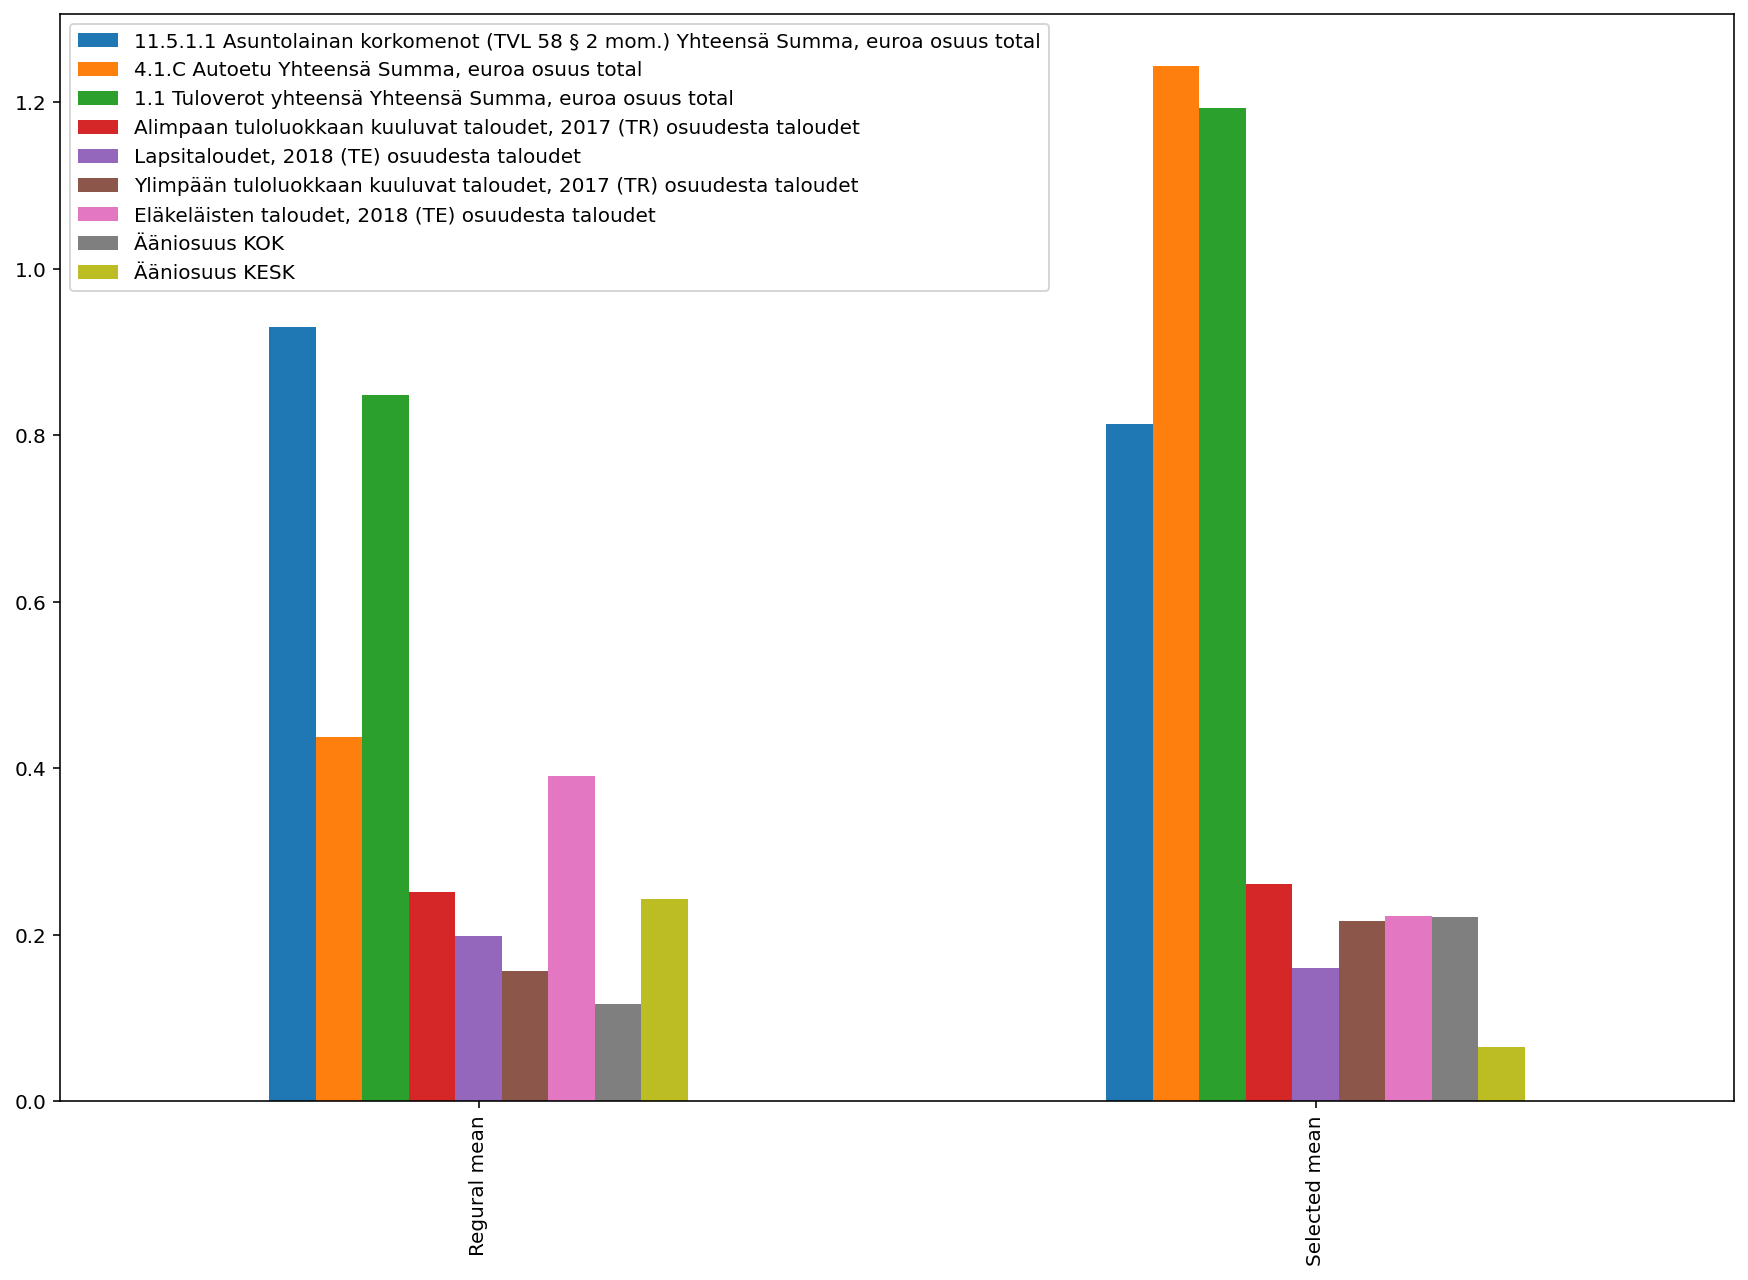

In [23]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=col_num, scaled=False)

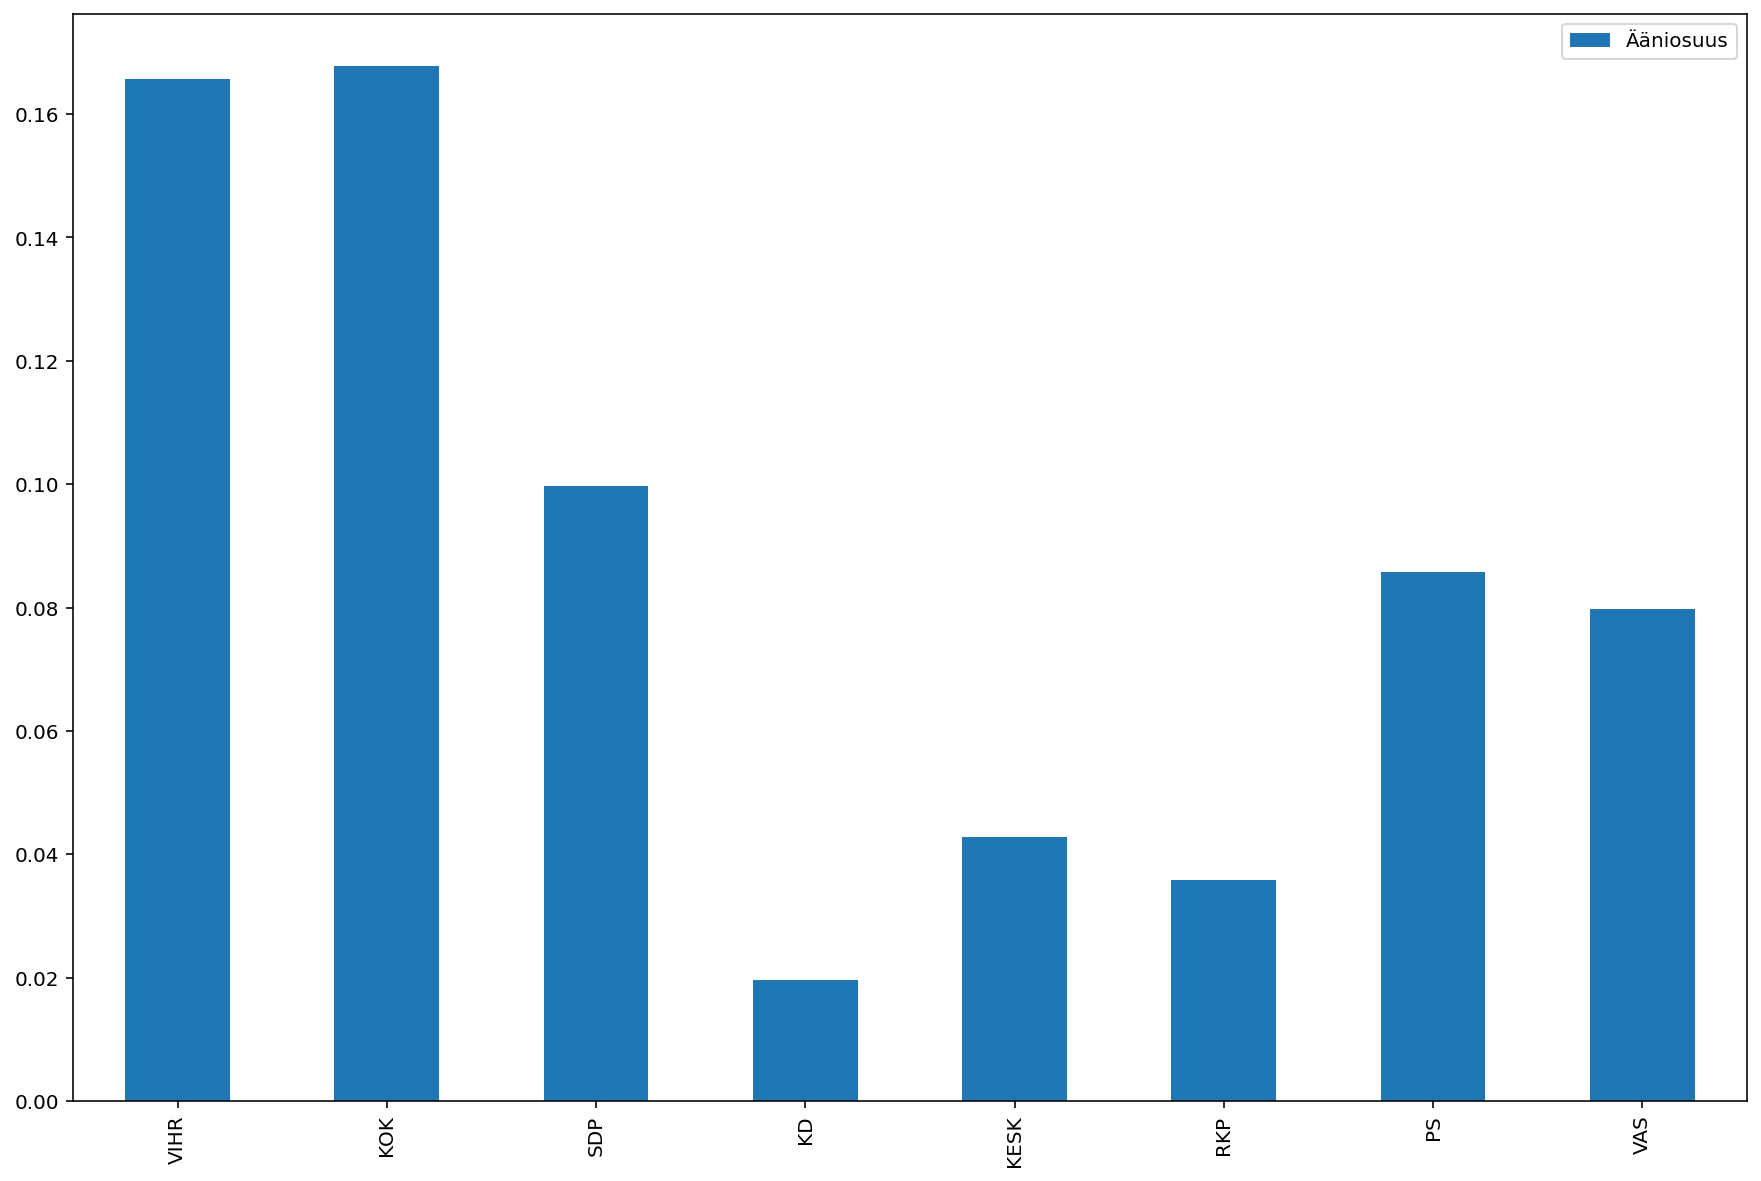

In [24]:
aanet = show_real_share(compare_to, all_included_columns_2, share_of_votes, total_votes, list_of_parties)

In [25]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=col_num)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
606        20500         TURKU            Turku                        6580.0   
615        20810         TURKU            Turku                       17007.0   
14         00260      HELSINKI         Helsinki                        5480.0   
2587       90140          OULU             Oulu                        3266.0   
2057       70100        KUOPIO           Kuopio                       11629.0   

     Suurin_puolue  Lapsitaloudet, 2018 (TE) osuudesta taloudet  \
606            KOK                                     0.059651   
615            KOK                                     0.134963   
14             KOK                                     0.112753   
2587          KESK                                     0.134336   
2057           KOK                                     0.078573   

      Eläkeläisten taloudet, 2018 (TE) osuudesta taloudet  \
606                                              0.160634   
615                                              0.253828   
14                                               0.304208   
2587                                             0.336916   
2057                                             0.353251   

      Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
606                                                                0.454870   
615                                                                0.265116   
14                                                                 0.171860   
2587                                                               0.248791   
2057                                                               0.313635   

      Ylimpään tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
606                                                                0.113718   
615                                                                0.168630   
14                                                                 0.411500   
2587                                                               0.179473   
2057                                                               0.158726   

      11.5.1.1 Asuntolainan korkomenot (TVL 58 § 2 mom.) Yhteensä Summa, euroa osuus total  \
606                                                                               0.338411   
615                                                                               0.822967   
14                                                                                1.124554   
2587                                                                              0.891776   
2057                                                                              0.623896   

      1.1 Tuloverot yhteensä Yhteensä Summa, euroa osuus total  \
606                                                   0.739270   
615                                                   1.040364   
14                                                    1.961639   
2587                                                  1.190808   
2057                                                  1.073268   

      4.1.C Autoetu Yhteensä Summa, euroa osuus total  
606                                          0.445953  
615                                          1.052062  
14                                           2.249319  
2587                                         1.146967  
2057                                         1.084094

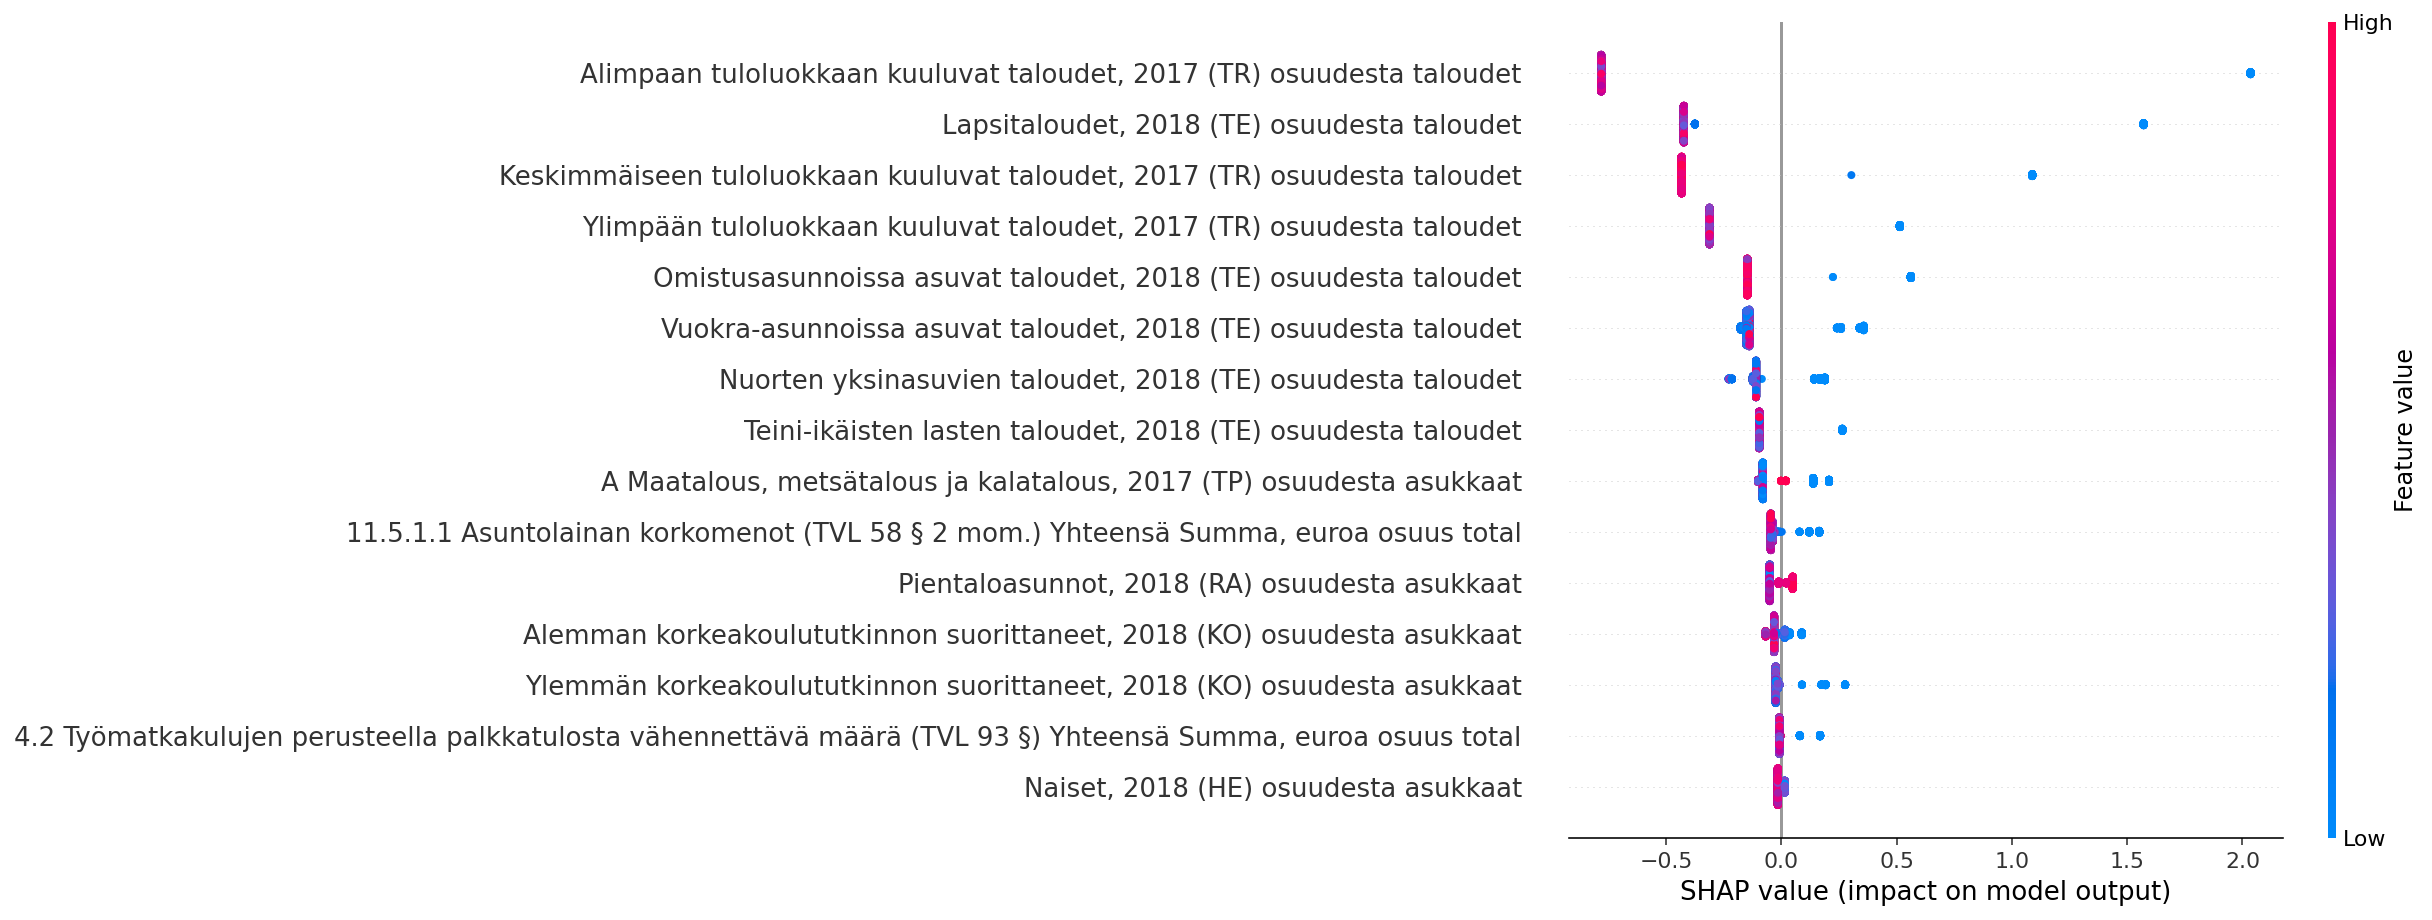

In [26]:
shap_index = 3
col_num = 7
compare_to = data[(data['cluster']) == shap_index].copy()
incl_mean = find_most_different(data, compare_to, all_included_columns,'mean')
incl_std = find_most_different(data, compare_to, all_included_columns,'std')
included_columns = [incl_mean] + [incl_std]
shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


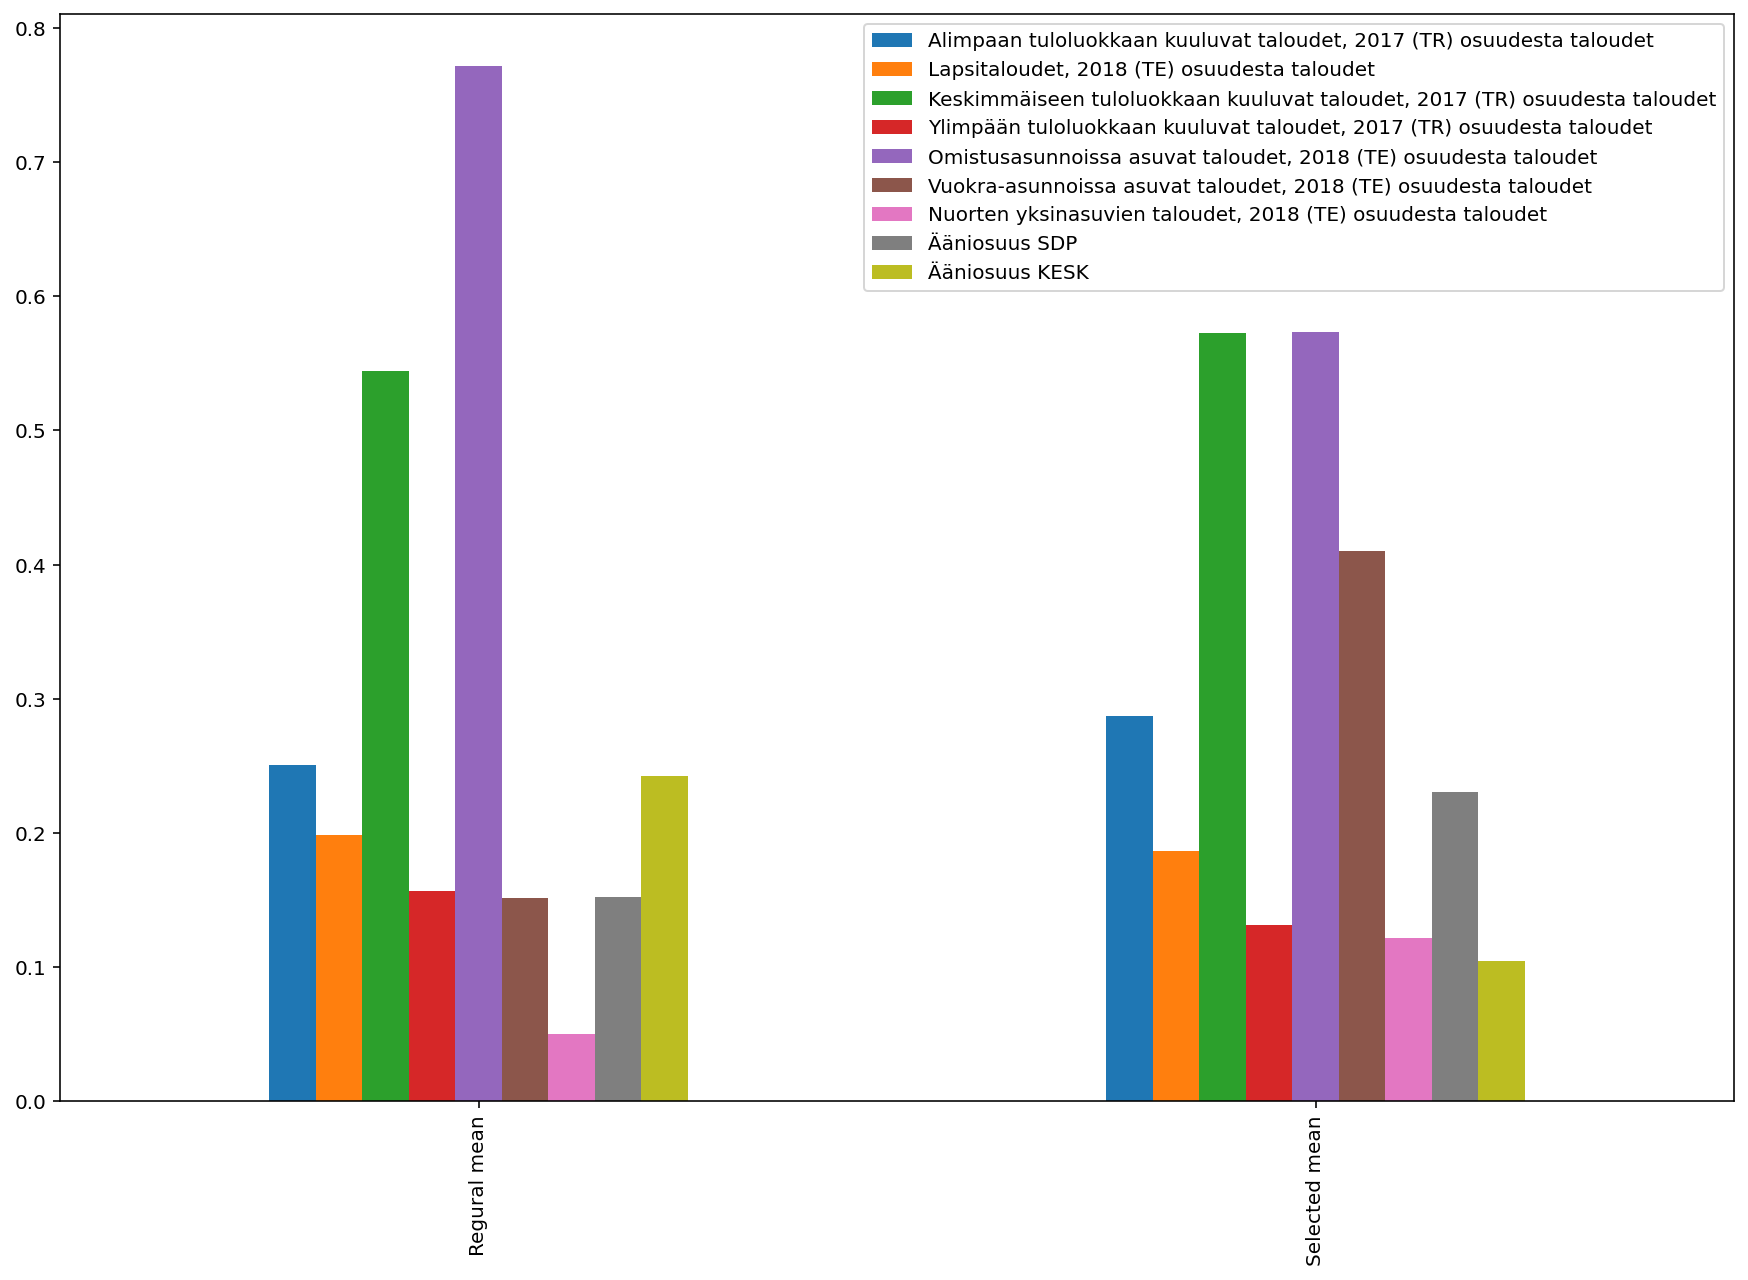

In [27]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=col_num, scaled=False)

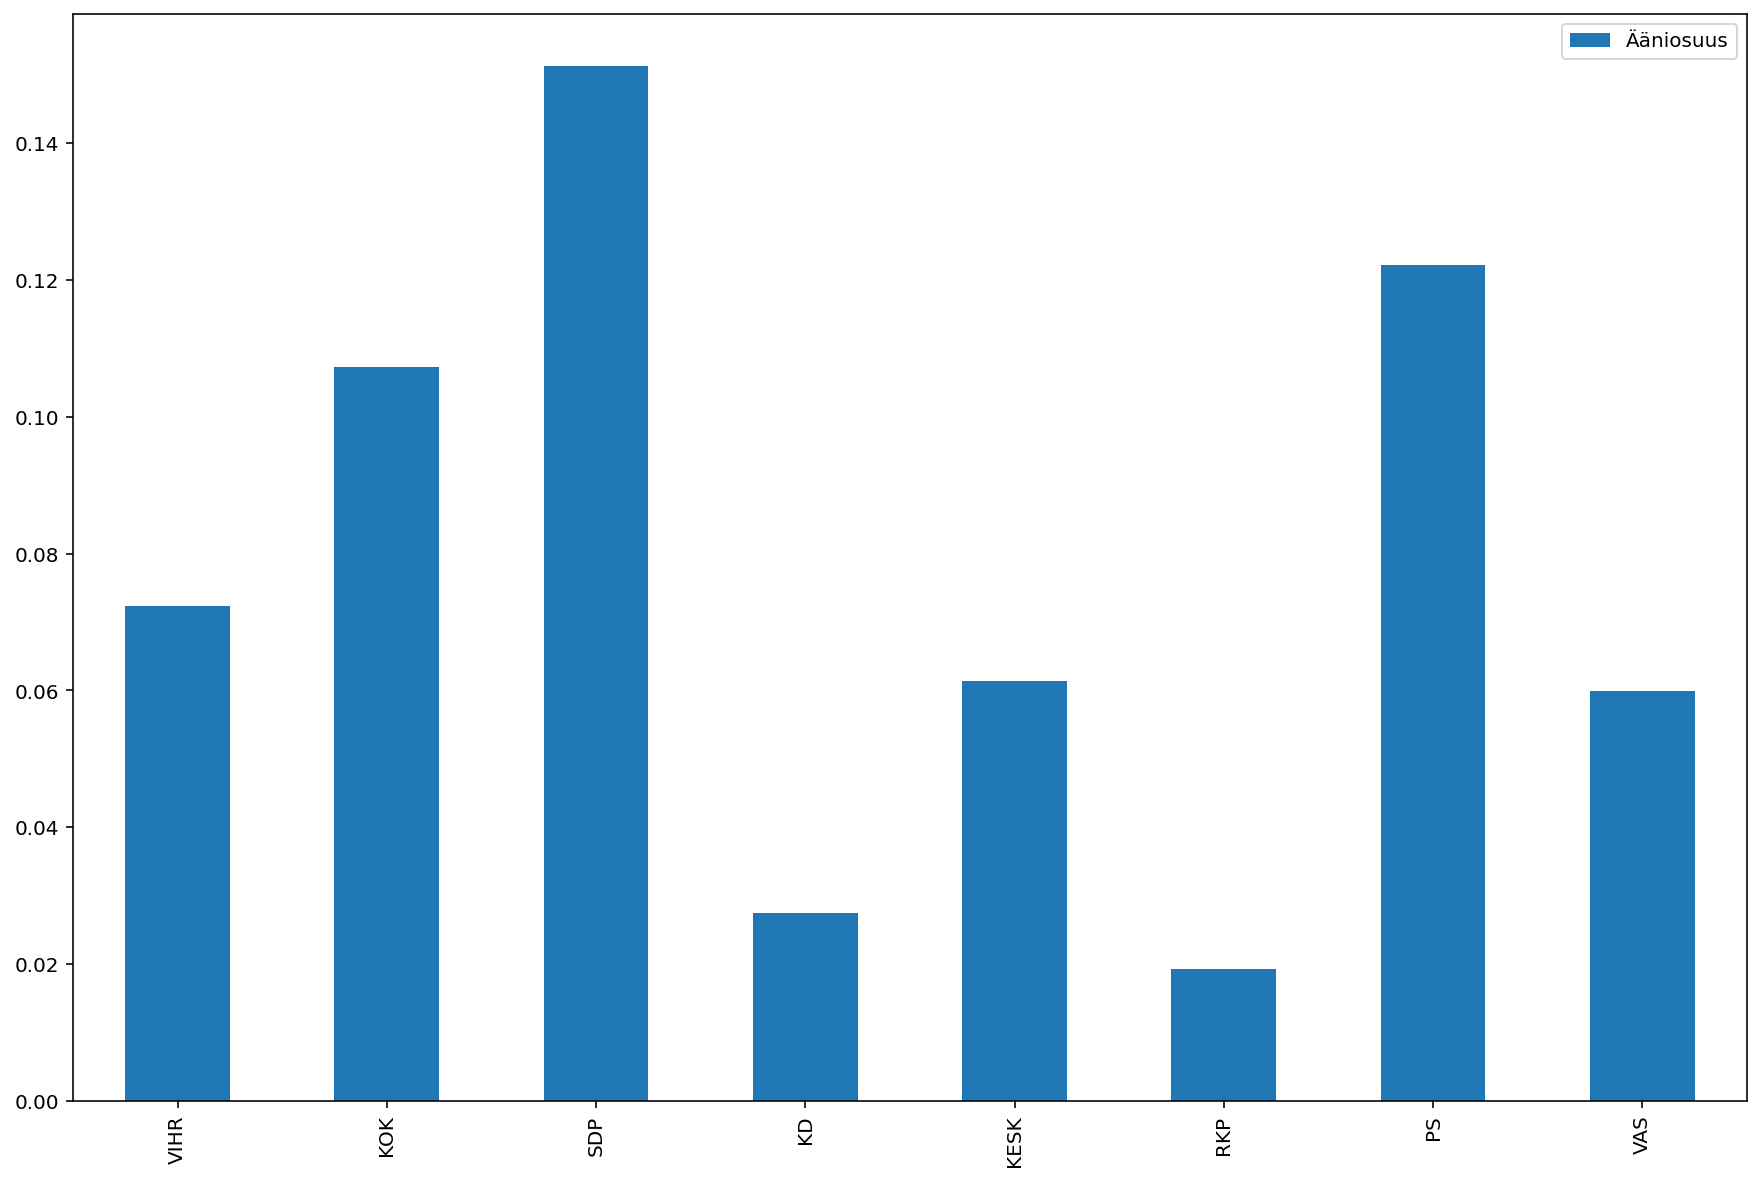

In [28]:
aanet = show_real_share(compare_to, all_included_columns_2, share_of_votes, total_votes, list_of_parties)

In [29]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=col_num)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
2793       96200     ROVANIEMI        Rovaniemi                        4830.0   
1460       50120       MIKKELI          Mikkeli                        1501.0   
1157       38710    KANKAANPÄÄ       Kankaanpää                        2049.0   
465        15300         LAHTI            Lahti                        4139.0   
1696       60320     SEINÄJOKI        Seinäjoki                        7289.0   

     Suurin_puolue  \
2793           KOK   
1460           KOK   
1157            PS   
465            SDP   
1696           KOK   

      Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet  \
2793                                                     0.218862   
1460                                                     0.179019   
1157                                                     0.129816   
465                                                      0.108065   
1696                                                     0.174950   

      Lapsitaloudet, 2018 (TE) osuudesta taloudet  \
2793                                     0.109593   
1460                                     0.144812   
1157                                     0.140704   
465                                      0.274644   
1696                                     0.244183   

      Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
2793                                                         0.458211   
1460                                                         0.624857   
1157                                                         0.551926   
465                                                          0.644175   
1696                                                         0.604999   

      Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
2793                                                         0.510244   
1460                                                         0.368301   
1157                                                         0.434673   
465                                                          0.339483   
1696                                                         0.384085   

      Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
2793                                                               0.350894   
1460                                                               0.326112   
1157                                                               0.416248   
465                                                                0.240907   
1696                                                               0.235852   

      Keskimmäiseen tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
2793                                                                    0.526504   
1460                                                                    0.589510   
1157                                                                    0.515075   
465                                                                     0.543490   
1696                                                                    0.566217   

      Ylimpään tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  
2793                                                               0.119024  
1460                                                               0.100342  
1157                                                               0.062814  
465                                                                0.171323  
1696                                                               0.163172

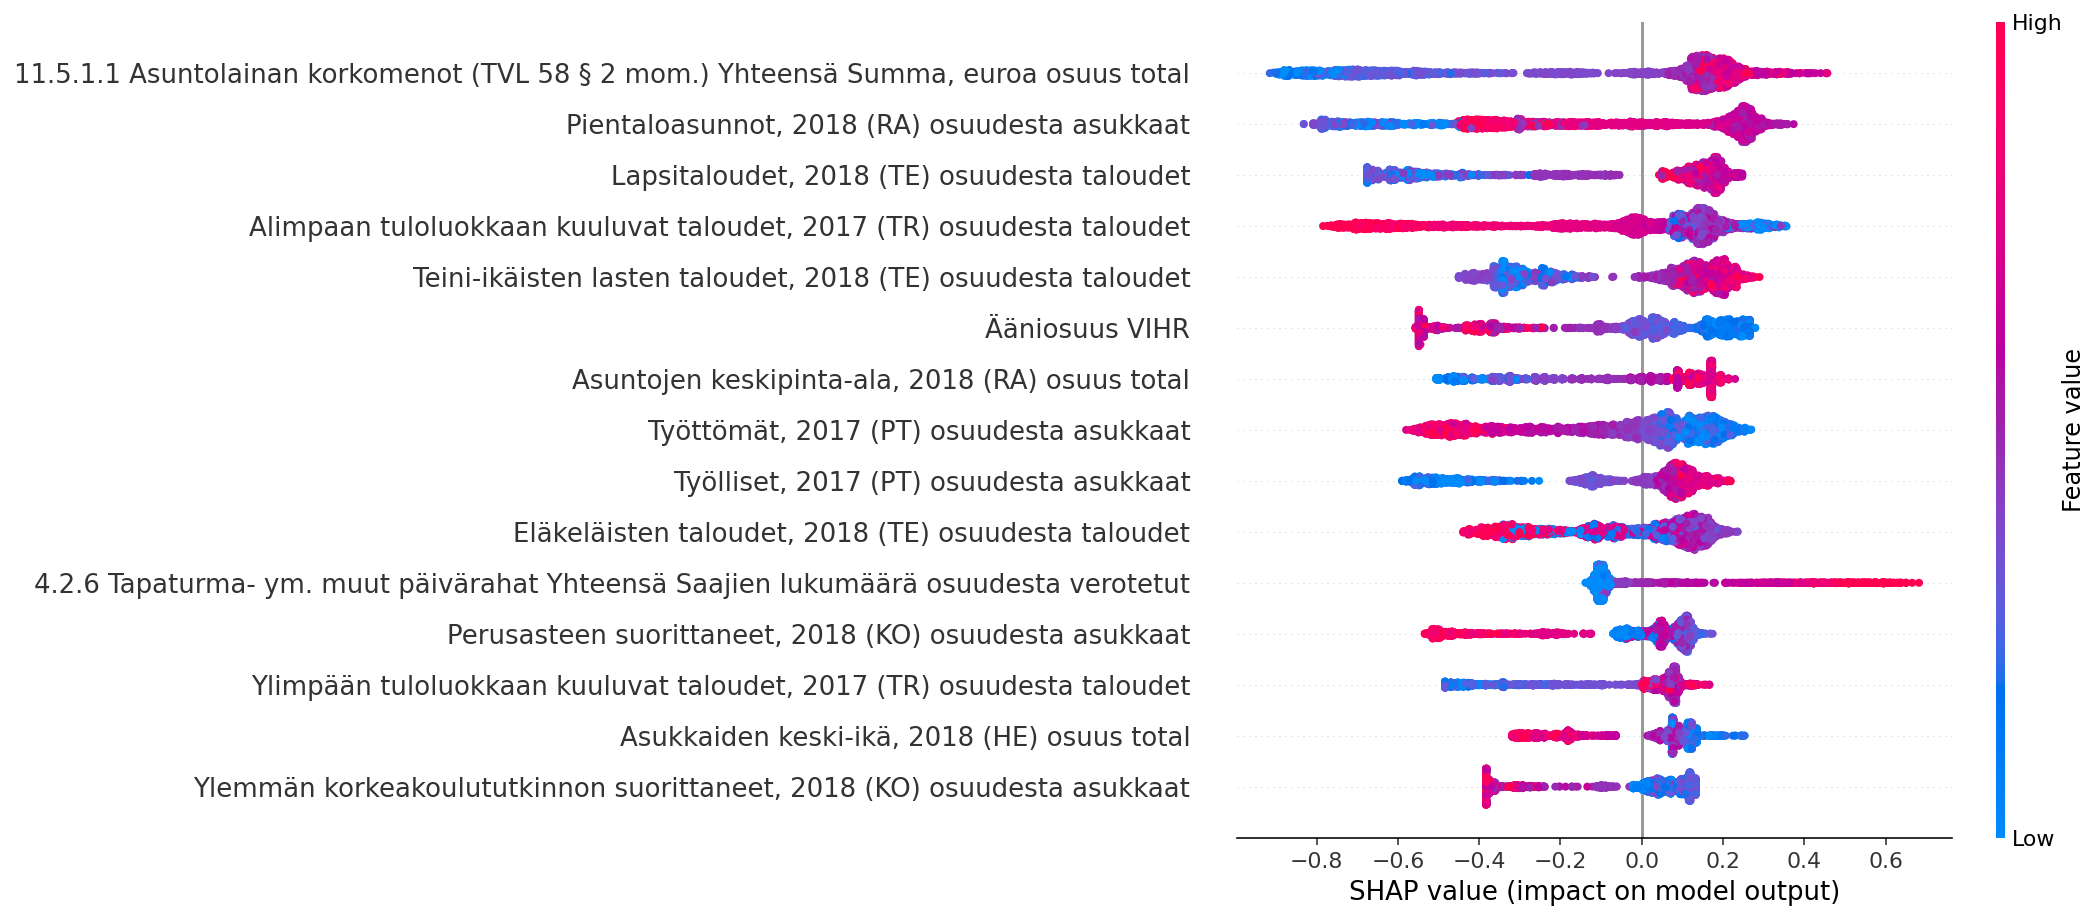

In [30]:
shap_index = 4
col_num = 7
compare_to = data[(data['cluster']) == shap_index].copy()
incl_mean = find_most_different(data, compare_to, all_included_columns,'max')
incl_std = find_most_different(data, compare_to, all_included_columns,'std')
included_columns = [incl_mean] + [incl_std]
shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


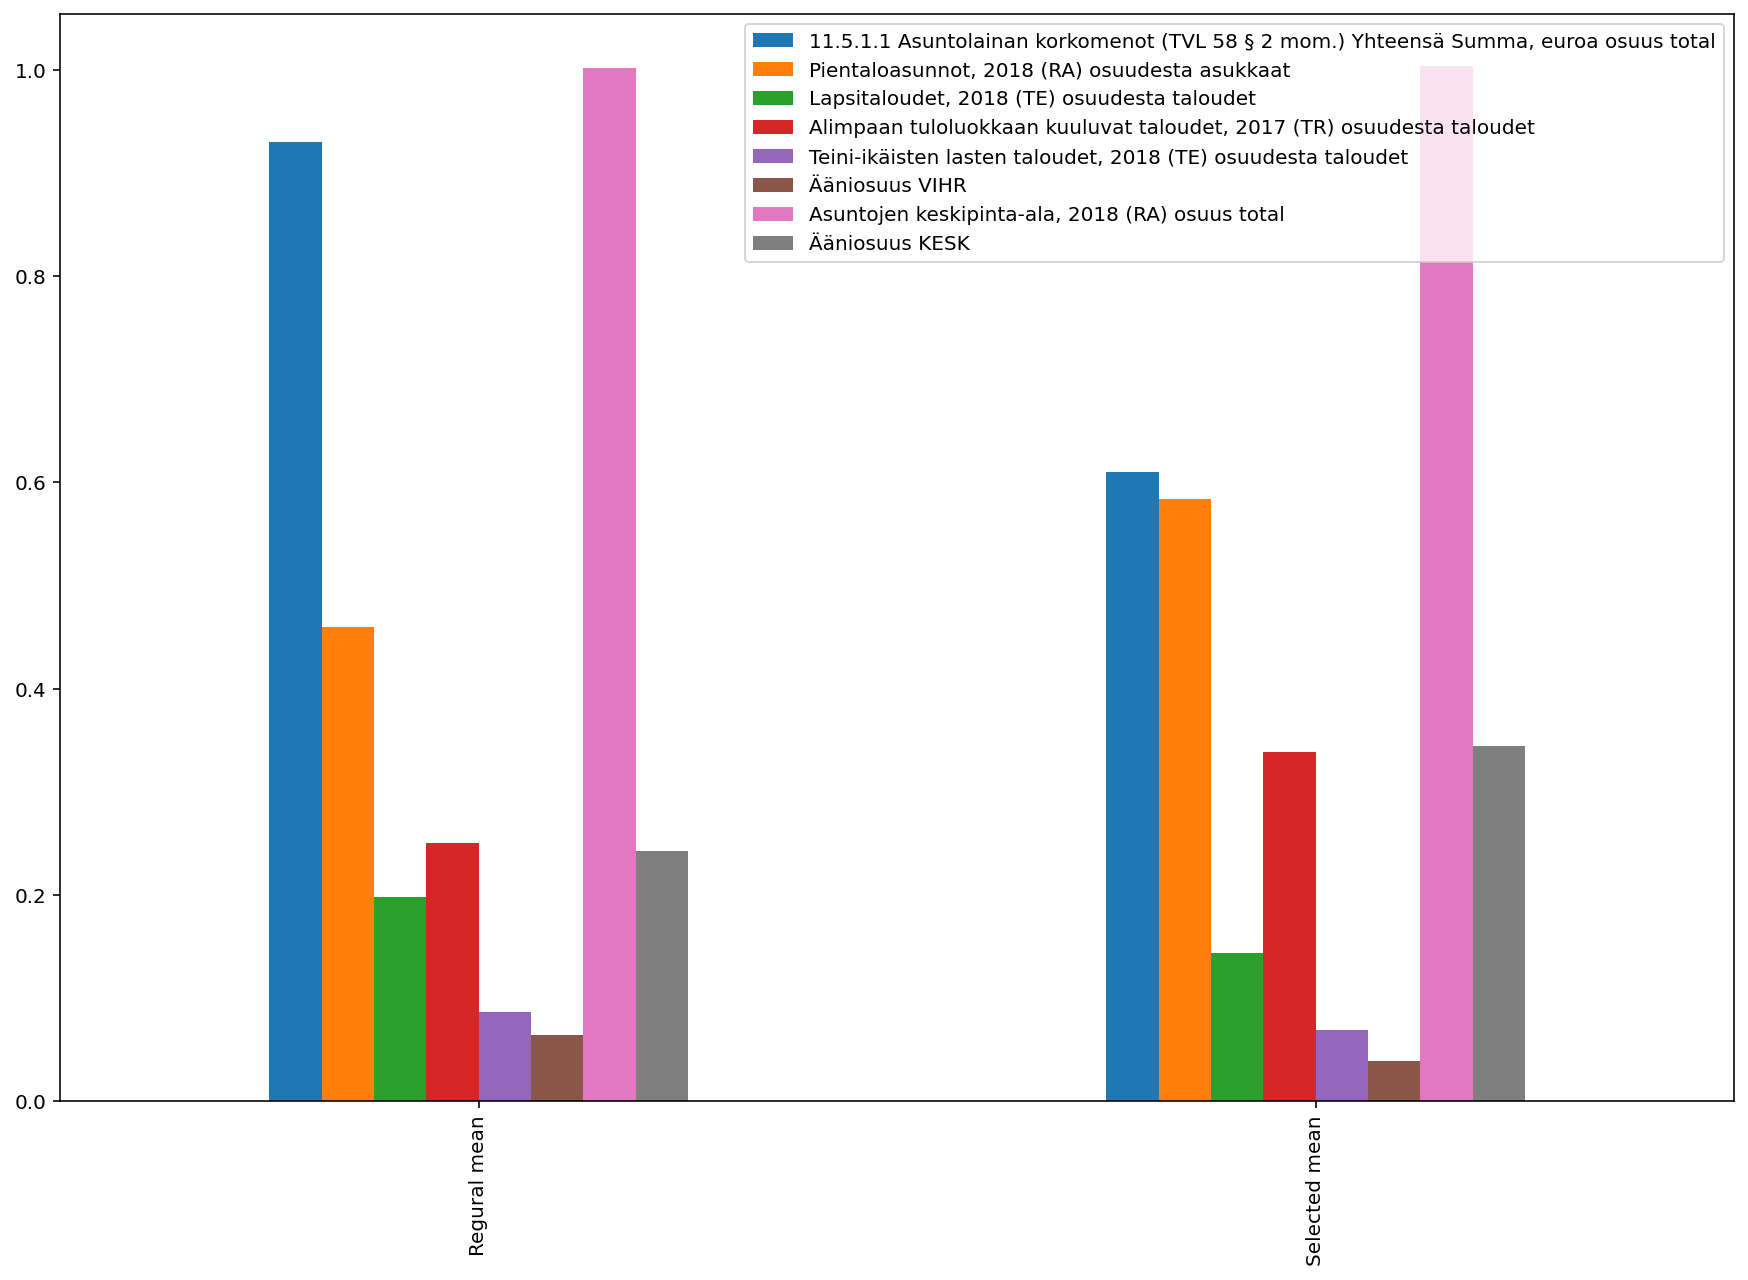

In [31]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=col_num, scaled=False)

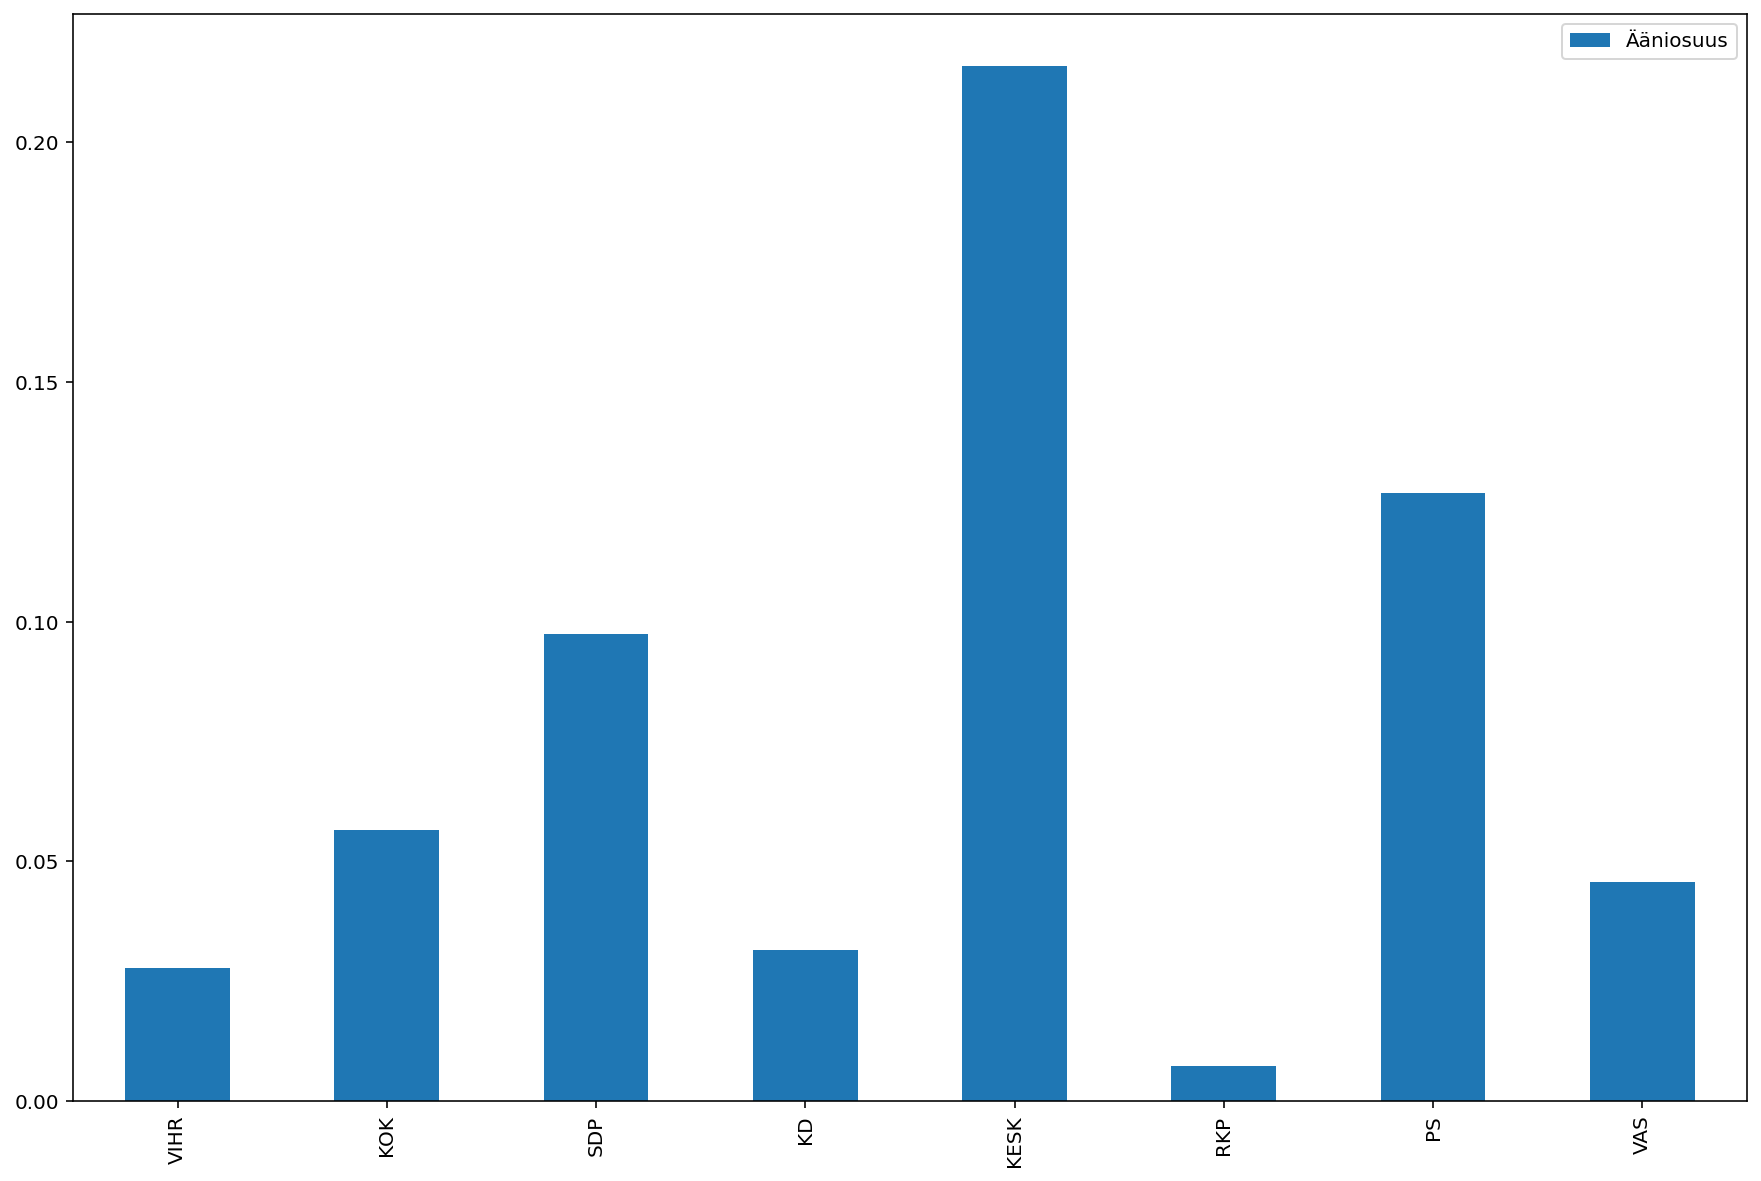

In [32]:
aanet = show_real_share(compare_to, all_included_columns_2, share_of_votes, total_votes, list_of_parties)

In [33]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=col_num)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
2896       97715       RAISKIO            Ranua                         183.0   
2436       83910     PAALASMAA            Juuka                          78.0   
2760       95690    MELLAKOSKI        Ylitornio                         164.0   
2901       97785     KELANKYLÄ            Ranua                          71.0   
2968       99980       UTSJOKI          Utsjoki                         686.0   

     Suurin_puolue  Asuntojen keskipinta-ala, 2018 (RA) osuus total  \
2896          KESK                                         0.961987   
2436           SDP                                         1.008196   
2760          KESK                                         0.995594   
2901          KESK                                         1.013447   
2968          KESK                                         0.902126   

      Pientaloasunnot, 2018 (RA) osuudesta asukkaat  \
2896                                       0.617486   
2436                                       0.628205   
2760                                       0.646341   
2901                                       0.507042   
2968                                       0.575802   

      Lapsitaloudet, 2018 (TE) osuudesta taloudet  \
2896                                     0.103093   
2436                                     0.093023   
2760                                     0.129412   
2901                                     0.133333   
2968                                     0.142029   

      Teini-ikäisten lasten taloudet, 2018 (TE) osuudesta taloudet  \
2896                                                      0.051546   
2436                                                      0.023256   
2760                                                      0.070588   
2901                                                      0.100000   
2968                                                      0.072464   

      Alimpaan tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
2896                                                               0.381443   
2436                                                               0.418605   
2760                                                               0.376471   
2901                                                               0.333333   
2968                                                               0.263768   

      11.5.1.1 Asuntolainan korkomenot (TVL 58 § 2 mom.) Yhteensä Summa, euroa osuus total  \
2896                                                                              0.162866   
2436                                                                              0.000000   
2760                                                                              0.463419   
2901                                                                              0.000000   
2968                                                                              0.581464   

      Ääniosuus VIHR  
2896        0.031056  
2436        0.033333  
2760        0.011236  
2901        0.018868  
2968        0.100000

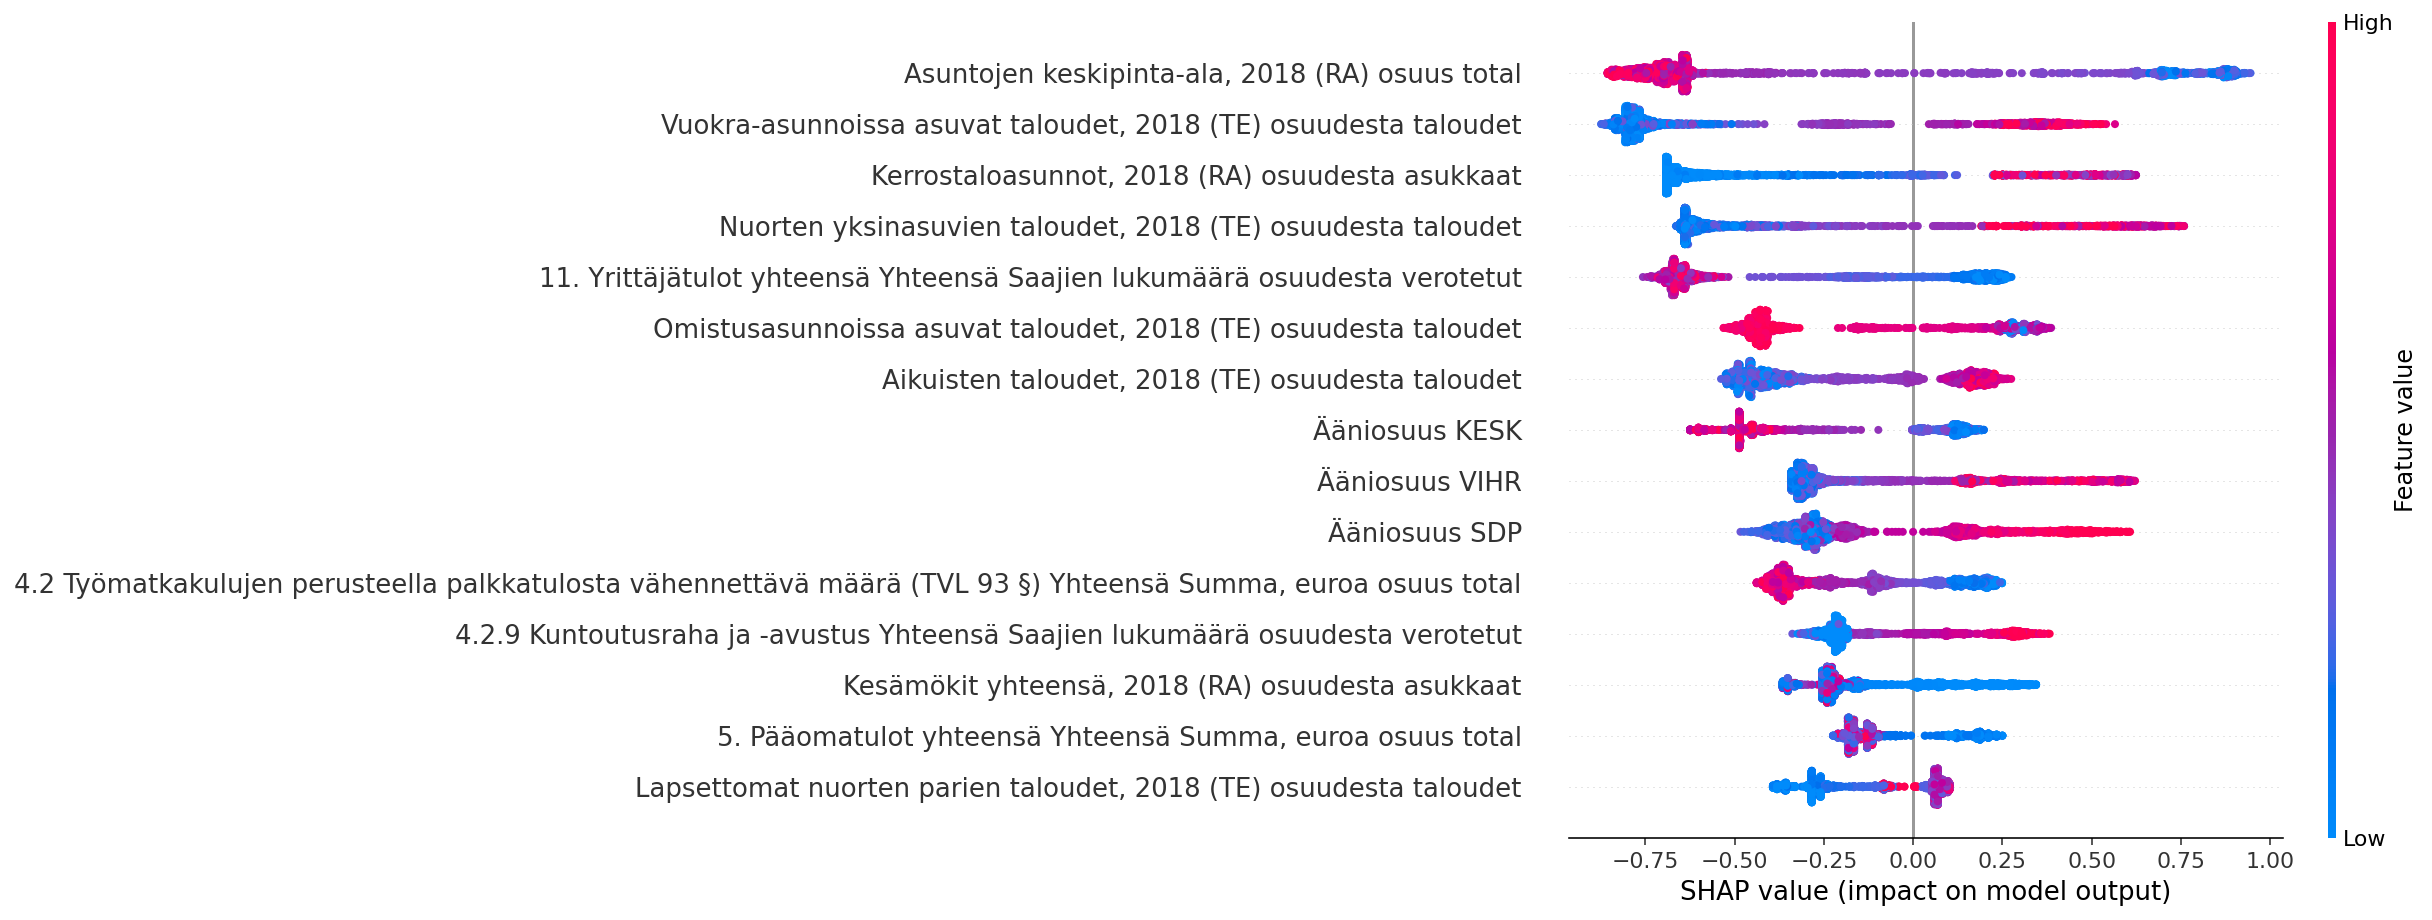

In [34]:
shap_index = 5
col_num = 7
compare_to = data[(data['cluster']) == shap_index].copy()
incl_mean = find_most_different(data, compare_to, all_included_columns,'mean')
incl_std = find_most_different(data, compare_to, all_included_columns,'std')
included_columns = [incl_mean] + [incl_std]
shap.summary_plot(shap_values[shap_index], X,  max_display=15)

invalid value encountered in true_divide
invalid value encountered in true_divide


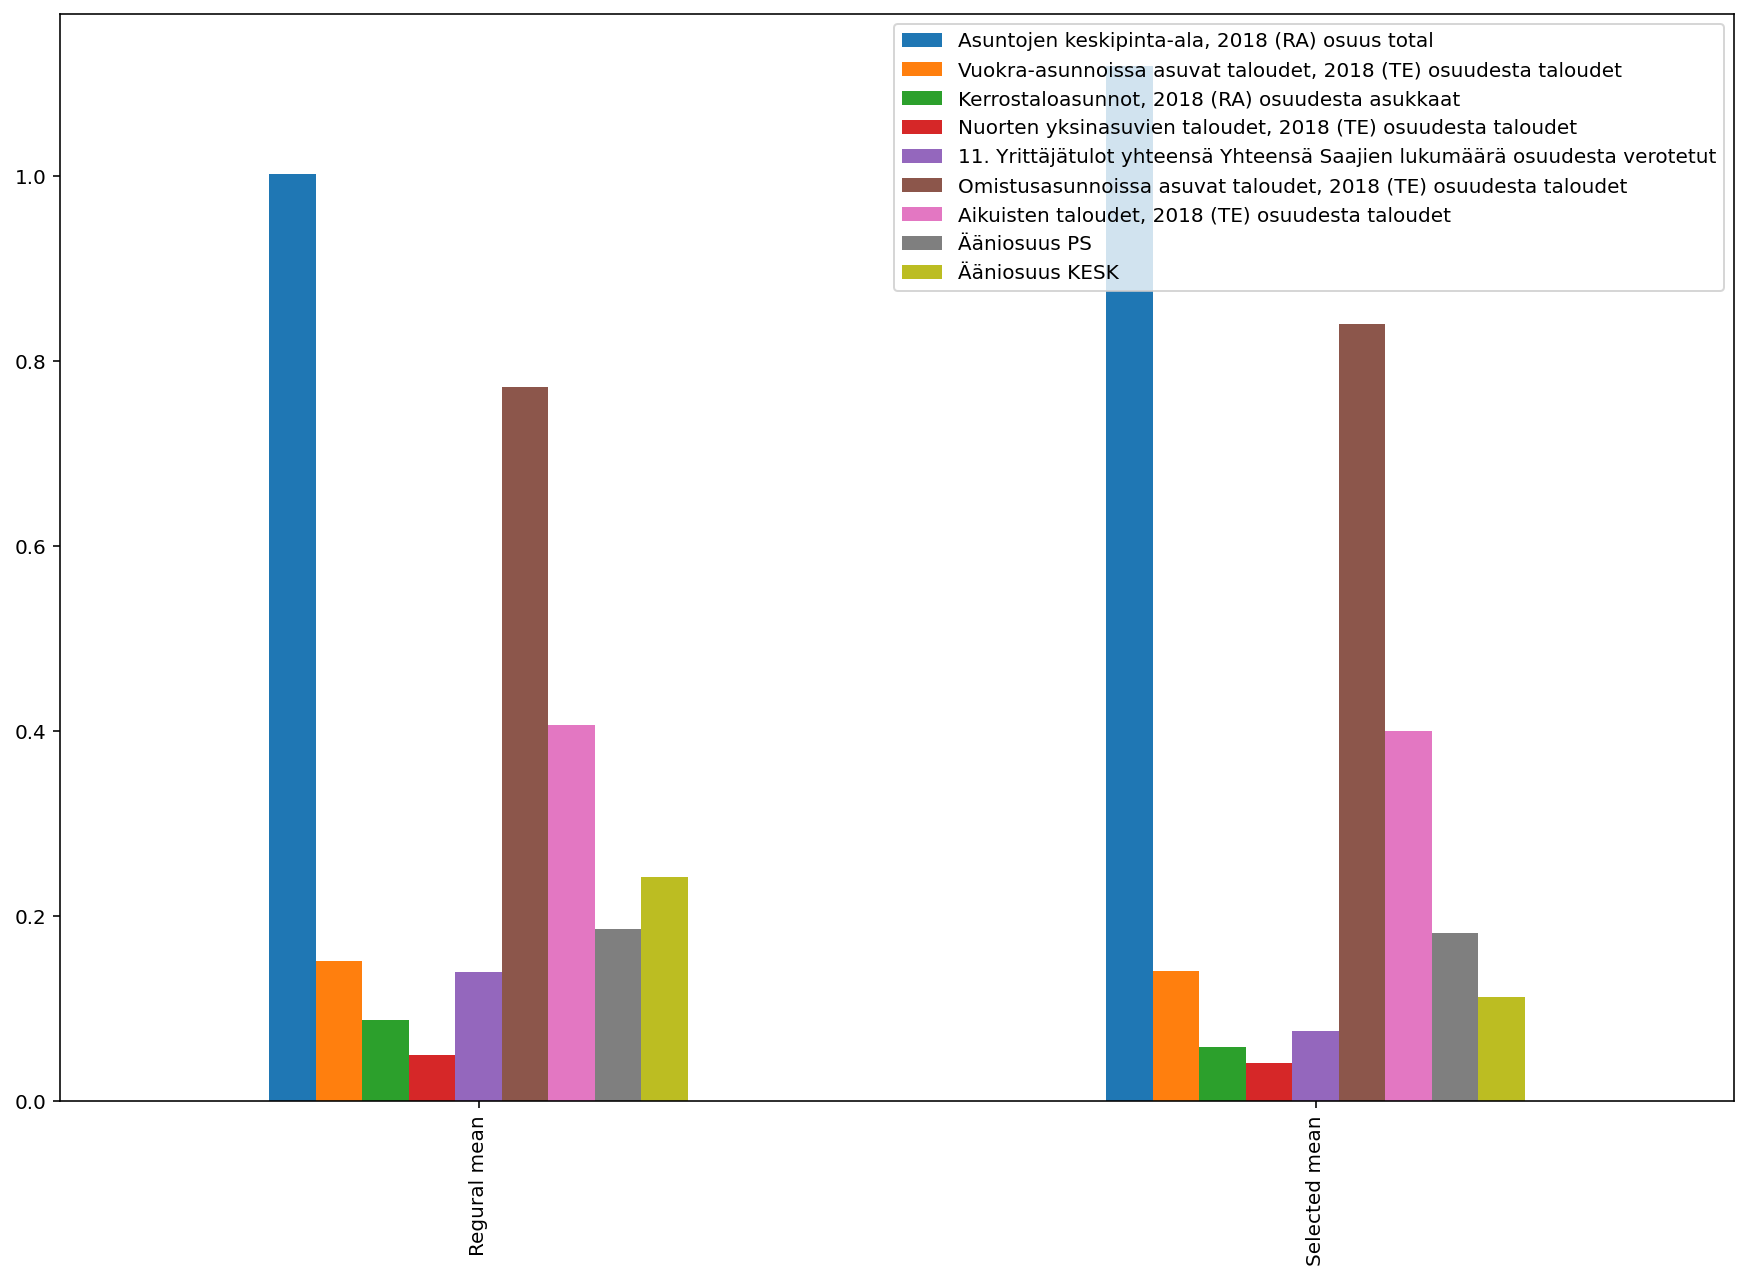

In [35]:
stats_data, k = plot_difference(data, compare_to, X, included_columns, shap_values, shap_index, col_num=col_num, scaled=False)

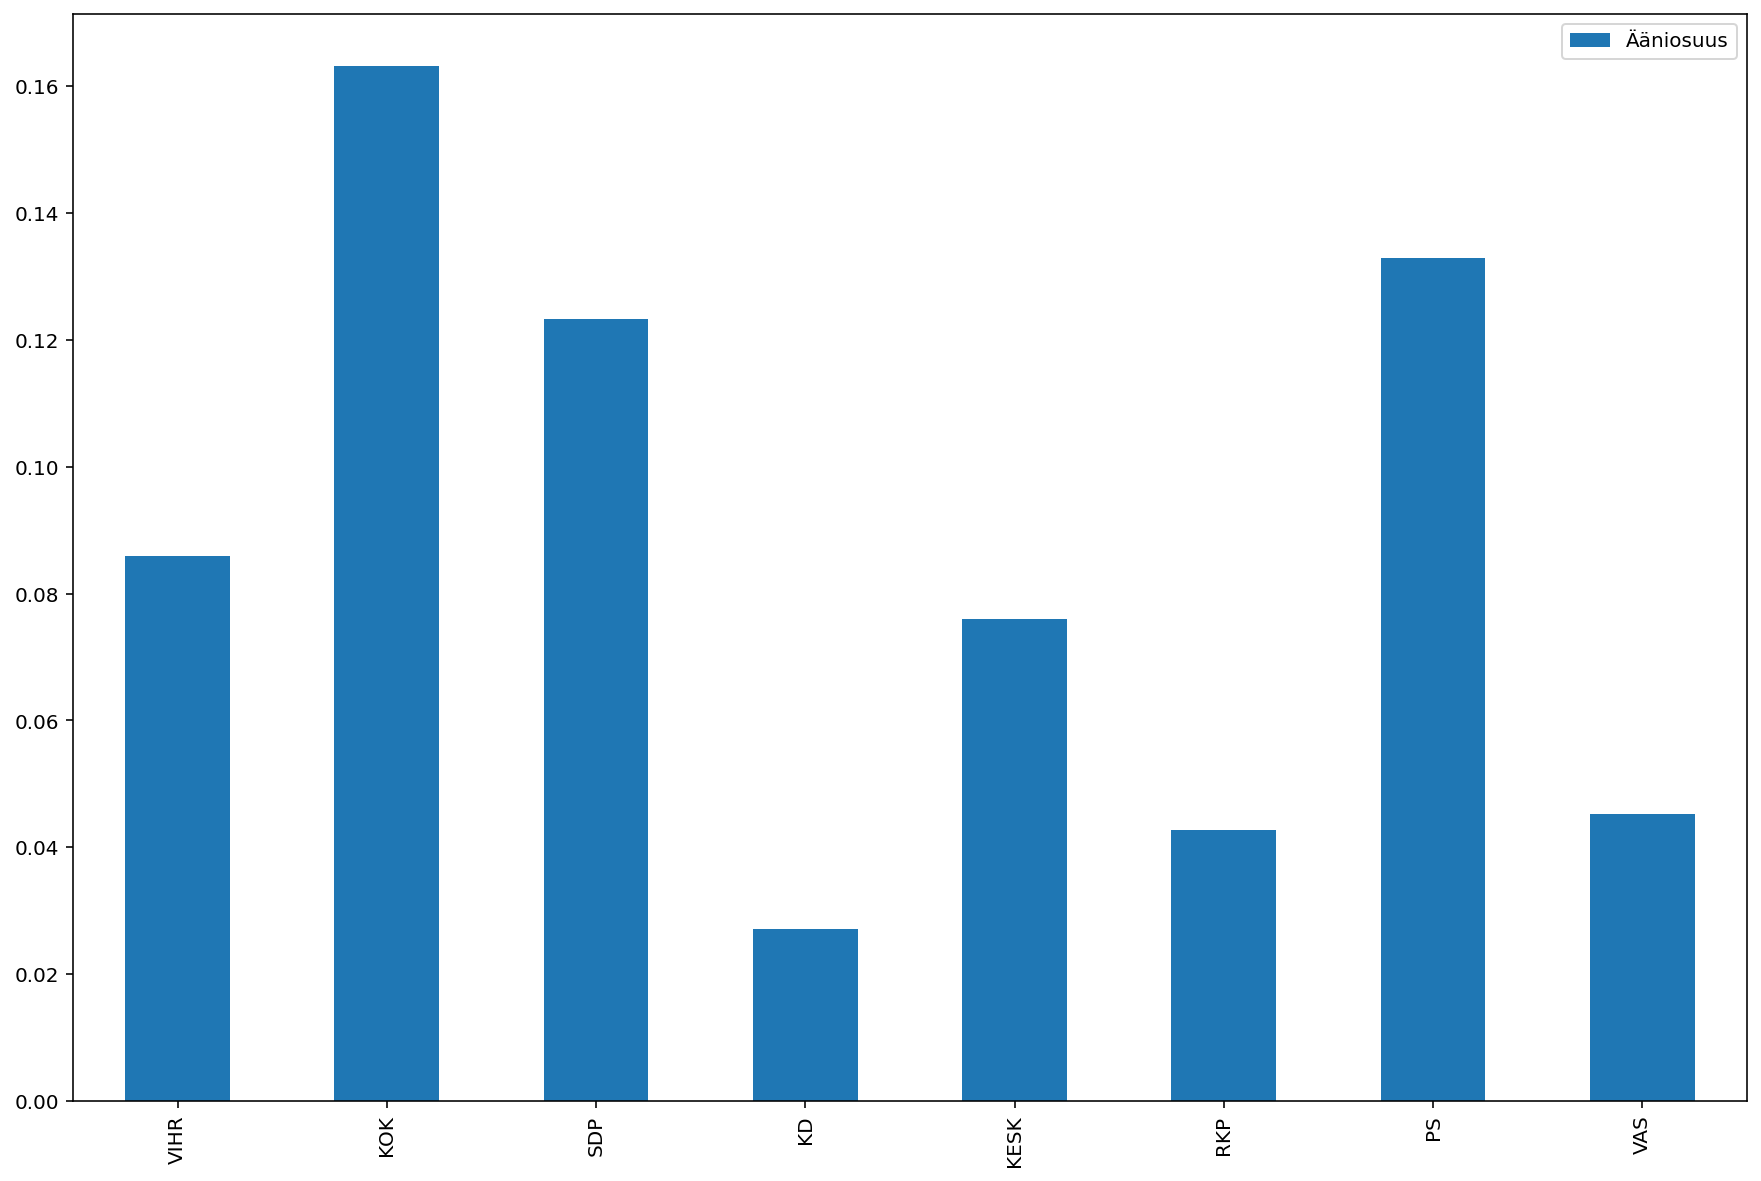

In [36]:
aanet = show_real_share(compare_to, all_included_columns_2, share_of_votes, total_votes, list_of_parties)

In [37]:
new = ['Postinumero','postcode_name', 'muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_df, k2, col_list = create_example_df(compare_to, X, new, shap_index, shap_values, col_num=col_num)
new_df.sample(5)

Postinumero postcode_name muncipality_name  Asukkaat yhteensä, 2018 (HE)  \
1055       33920      PIRKKALA         Pirkkala                        1250.0   
233        04230        KERAVA           Kerava                        7652.0   
1115       36240     KANGASALA        Kangasala                        5004.0   
1546       53400  LAPPEENRANTA     Lappeenranta                        1905.0   
199        03100       NUMMELA            Vihti                       15609.0   

     Suurin_puolue  Asuntojen keskipinta-ala, 2018 (RA) osuus total  \
1055           SDP                                         1.121619   
233            KOK                                         0.927331   
1115           KOK                                         0.904226   
1546           SDP                                         1.126870   
199            KOK                                         0.872720   

      Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat  \
1055                                         0.000000   
233                                          0.173941   
1115                                         0.215827   
1546                                         0.003150   
199                                          0.191684   

      Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet  \
1055                                                     0.020833   
233                                                      0.068209   
1115                                                     0.104661   
1546                                                     0.014212   
199                                                      0.095916   

      Aikuisten taloudet, 2018 (TE) osuudesta taloudet  \
1055                                          0.335648   
233                                           0.420225   
1115                                          0.463940   
1546                                          0.383721   
199                                           0.460371   

      Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
1055                                                         0.916667   
233                                                          0.731317   
1115                                                         0.752858   
1546                                                         0.962532   
199                                                          0.648442   

      Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
1055                                                         0.071759   
233                                                          0.260083   
1115                                                         0.229551   
1546                                                         0.018088   
199                                                          0.332080   

      11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut  
1055                                                                   0.048504  
233                                                                    0.041470  
1115                                                                   0.048916  
1546                                                                   0.094072  
199                                                                    0.052305

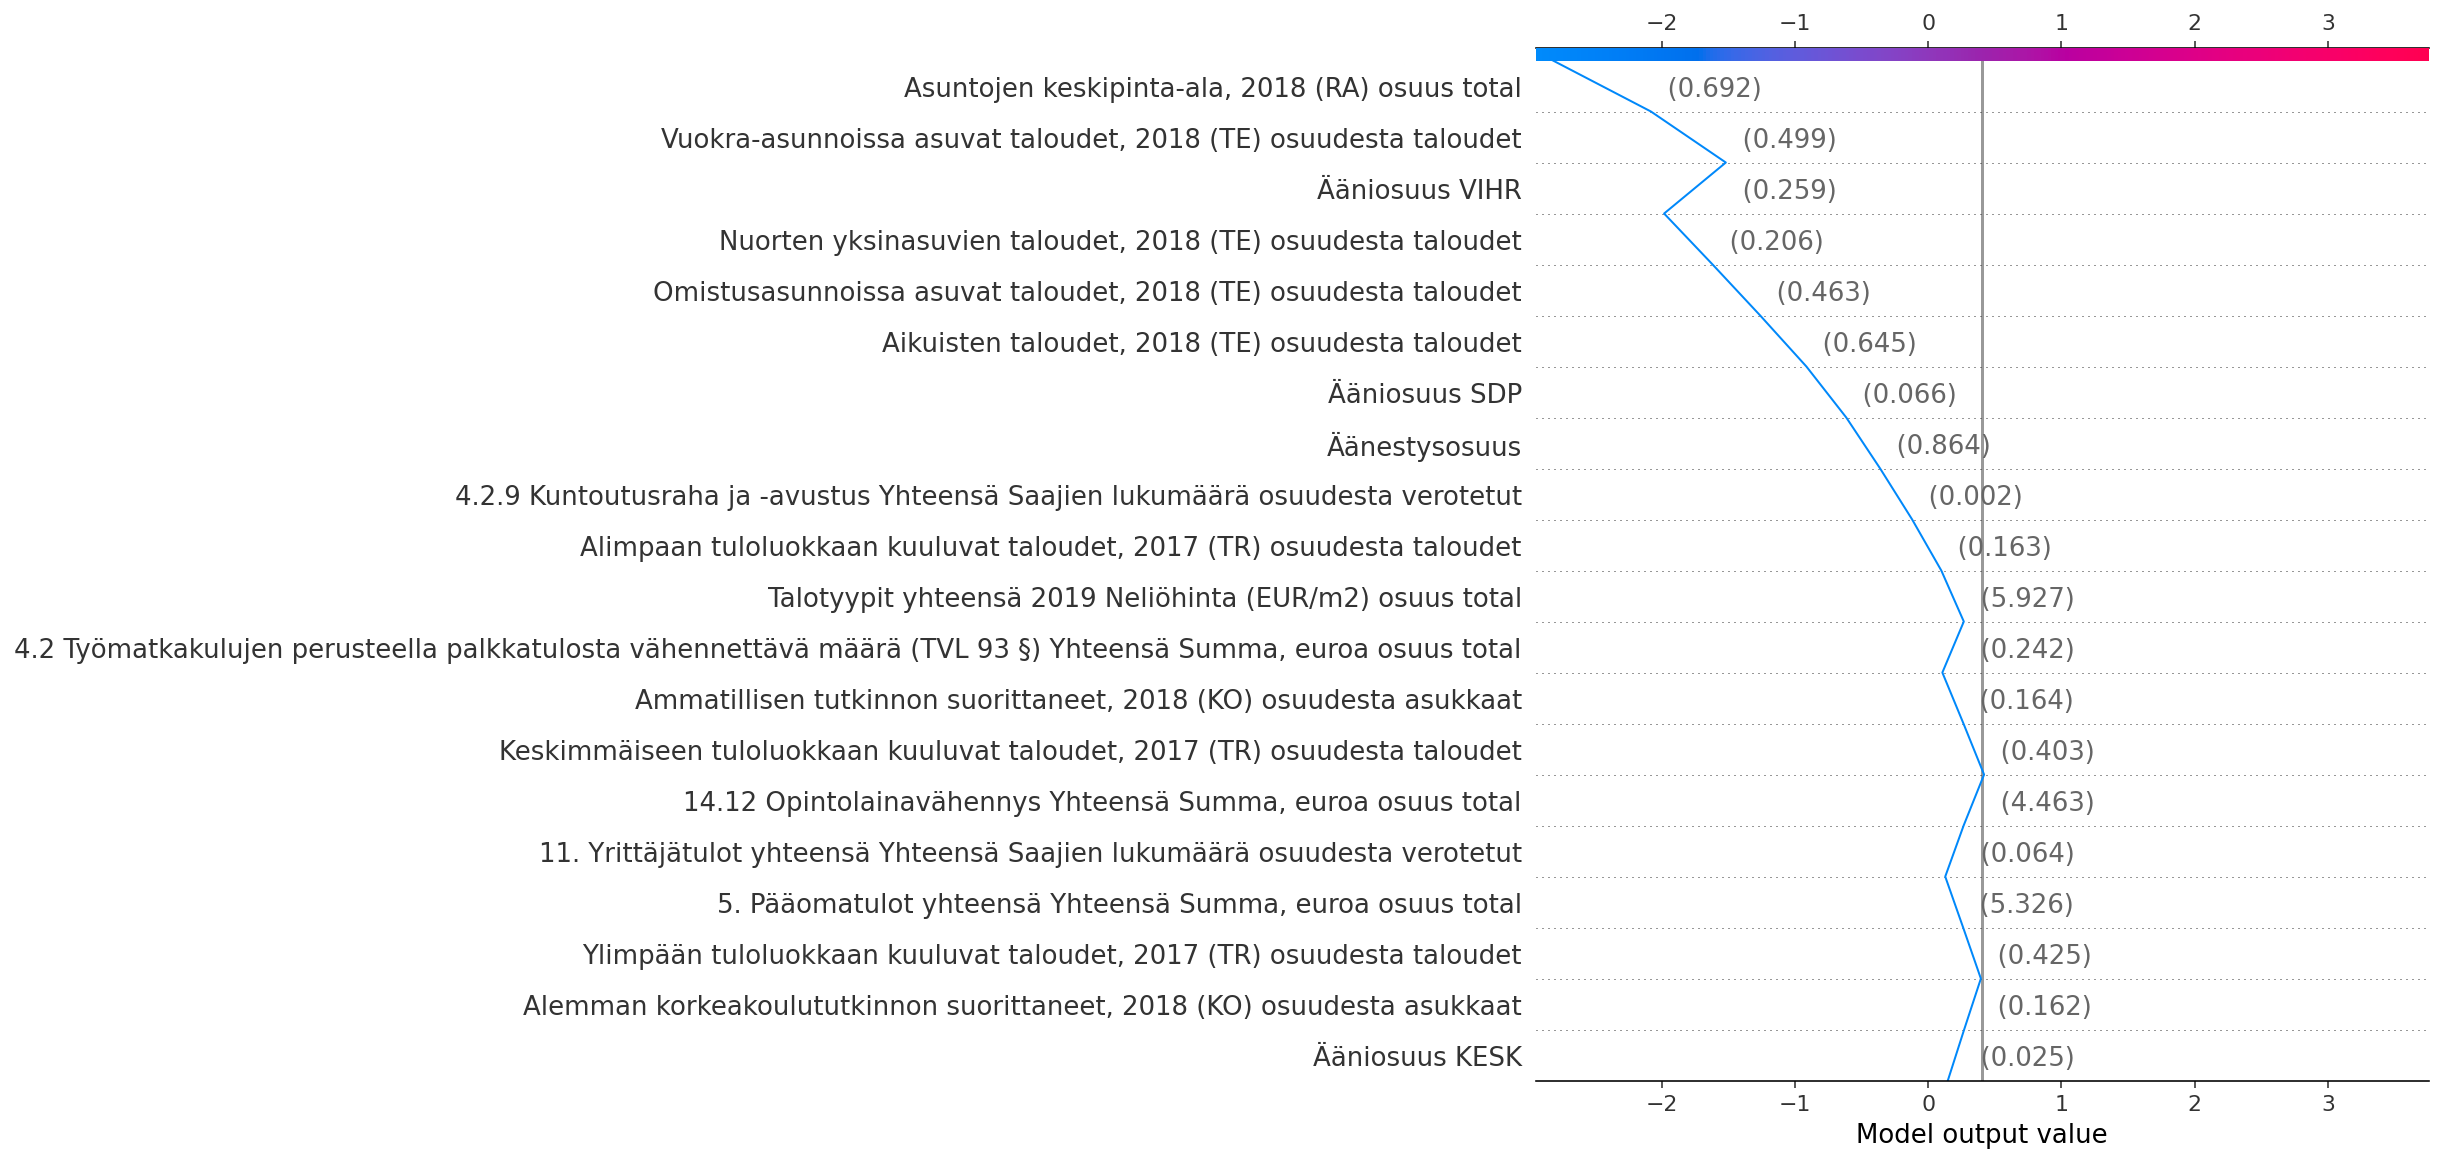

In [38]:
pnro = '02160'
id_col = 'Postinumero'
target='cluster'
idx = data[data[id_col]==pnro].index.item()
shap_index = data[data[id_col]==pnro][target].item()

shap.decision_plot(shap_expected_value[shap_index], shap_values[shap_index][idx], X)


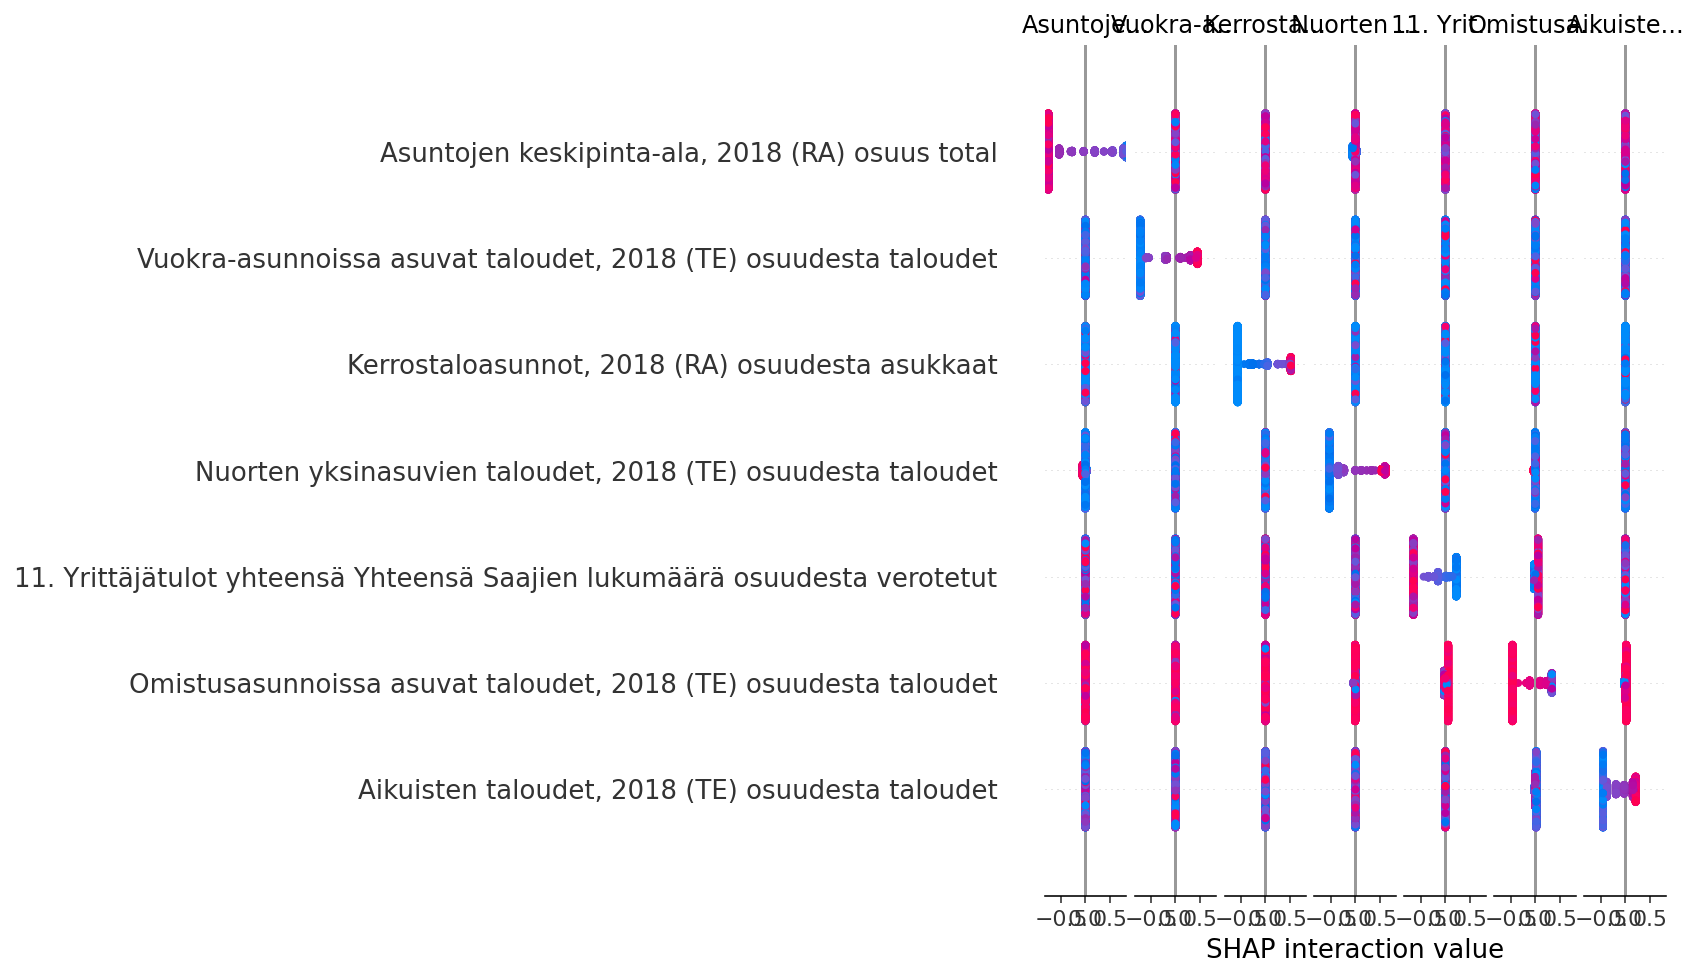

In [39]:
shap.summary_plot(shap_interaction_values[shap_index], X)